#  **J&J PROBLEM STATEMENT 1**

## PREDICTING LENGTH OF STAY IN AN ICU 

### Dataset-MIMIC-III 

In [1]:
#Importing the required Python Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import seaborn as sns
%matplotlib inline


In [2]:
#Loading the required tables into pandas dataframe.



# Admissions information
df = pd.read_csv('MIMIC-III/ADMISSIONS.csv')

# Patient specific info
#col=['ROW_ID','SUBJECT_ID','GENDER','DOB','DOD','DOD_HOSP','DOD_SSN','EXPIRE_FLAG']
df_pat = pd.read_csv('MIMIC-III/PATIENTS.txt',sep=',')

# Intensive Care Unit (ICU) for each admission to hospital
df_icu = pd.read_csv('MIMIC-III/ICUSTAYS.csv')

# Services for each patient for the particular hospital admission
df_services = pd.read_csv('MIMIC-III/SERVICES.csv')

#Chart Events Information for each ICU_Stay
start = timer()
df_chartevents= pd.read_csv('MIMIC-III/CHARTEVENTS.csv',
    usecols = ["ICUSTAY_ID", "ITEMID", "CHARTTIME", "VALUENUM"],
    dtype = {"ICUSTAY_ID" : np.float64, "ITEMID" : np.float64, "CHARTTIME" : "str", "VALUENUM" : np.float64},
    parse_dates = ["CHARTTIME"]
    )
end = timer()
print("Elapsed time: ", end - start)

#Dictionary for various ITEM ID's given in CHARTEVENTS Table
df_itemID_dict = pd.read_csv('MIMIC-III/D_ITEMS.csv')

Elapsed time:  787.7928100089994


### DEFINING THE COHORT FOR OUR DATA ANALYSIS


- Patient's first ICU stay will only be considered to avoid any unwanted skewing of data.

- ICU stays with a minimum of 36 hour duration will only be considered.Our LOS prediction is based on data recieved on admission to ICU. First 24 hours  is assigned to collect required vitals and lab measurements info. A 12 hour window is added, considering the fuzziness associated with the process.

- Deceased patients will not be considered as their LOS prediction would be affected without an actual discharge.

- Neonates will not be considered as neonates and adults associated ICU factors need to be analysed independently. (MIMIC-III contains data for neonates and patients above age of 15 only)

In [3]:
#Accessing the Information about ICU stays from ICUSTAYS Table
df_icu.head()

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0          MICU            52           52  2198-02-14 23:27:38   
1          MICU            52           52  2170-11-05 11:05:29   
2           CCU            57           57  2128-06-24 15:05:20   
3          SICU            52           23  2120-08-07 23:12:42   
4           CCU            57           57  2186-12-25 21:08:04   

               OUTTIME     LOS  
0  2198-02-18 05:26:11  3.2490  
1  2170-11-08 17:46:57  3.2788  
2  2128-06-27 12:32:29  2.8939  
3  2120-08-10 00:39:04  2.0600  
4  2186-12-27 12:01:13  1.6202

In [4]:
#Size check
df_icu.shape

(61532, 12)

In [5]:
#EXCLUSION 1
# Only the first ICU stay associated with a particular hospital admission is considered.
# Hence Re-admissions to the ICU are excluded
df_icu_1ststay = (df_icu.sort_values(["SUBJECT_ID", "INTIME"]).
                       groupby("SUBJECT_ID").
                       head(1)) 
df_icu_1ststay.shape


(46476, 12)

In [6]:
#Understanding LOS
df_icu_1ststay['LOS'].describe()

count    46467.000000
mean         5.042017
std         10.317132
min          0.000100
25%          1.067100
50%          2.027800
75%          4.394550
max        171.622700
Name: LOS, dtype: float64

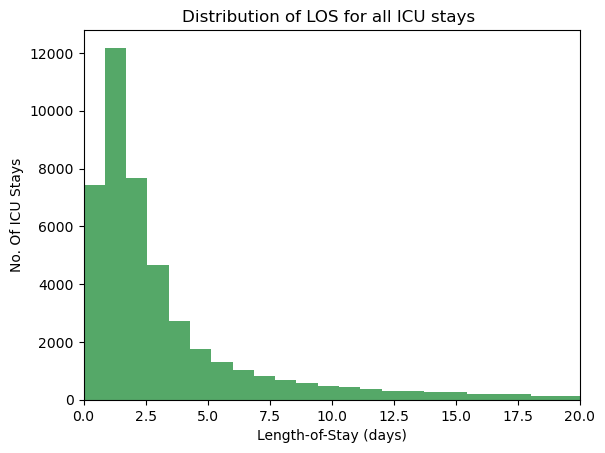

In [9]:
# LOS Distribution for ICU Stay
plt.hist(df_icu_1ststay['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 20)
plt.title('Distribution of LOS for all ICU stays ')
plt.ylabel('No. Of ICU Stays')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [10]:
#EXCLUSION 2
#Patients staying in the ICU for minimum 36 hours will only be considered

filt_26hrs=(df_icu_1ststay["LOS"]>=1.1)
df_icu_1ststay=df_icu_1ststay.loc[filt_26hrs]
df_icu_1ststay.shape

(34156, 12)

In [11]:
#Choosing the required Height,Weight,Vitals and lab values from CHARTEVENTS Table 

#ITEM ID's To be considered(Manually chosen From D_ITEMS Table)
#----------------------------------------------
#Height,Weight,Heart Rate,Respiration Rate,Arterial Blood Pressure(Sys,Dia,Mean),Temp,Oxygen Saturation,GCSTotal,Creatinine


ITEM_ID_Height_In=[1394,920]#(Inches)
ITEM_ID_Height_Cm=[226730,226707]
ITEM_ID_Weight=[762,226512]#(Kg)
ITEM_ID_Heart_Rate=[211,220045] #(bpm)
ITEM_ID_BP_SYS=[51,442,455,6701,220179,220050]#(mmHg)#Arterial BP [Systolic](c),	Arterial BP #2 [Systolic](c),Arterial Blood Pressure systolic(M)
ITEM_ID_BP_DIA=[8368,8440,8441,8555,220180,220051]#(mmHg)Arterial BP [Diastolic](c),	Arterial BP #2 [Diastolic](c),Arterial Blood Pressure Diastolic(M)	
ITEM_ID_BP_MEAN=[456,52,6702,443,220052,220181,225312]#insp/min(mmHg)
ITEM_ID_Resp_Rate=[615,618,220210,224690]##(insp/min)Total Resp rate/Resp Rate
ITEM_ID_Temp_DegF=[223761,678]#Fahrenheit
ITEM_ID_Temp_DegC=[223762,676]#Celcius
ITEM_ID_O2SAT=[646,220277]#(%)
ITEM_ID_GCS=[227013,198]
ITEM_ID_CREATININE=[791,220615]

In [12]:
#Accessing the CHARTEVENTS Table and choosing the rows based on our ITEMS ID's of chosen features
ITEM_ID_TOTAL= ITEM_ID_Height_In+ ITEM_ID_Height_Cm+ITEM_ID_Weight+ITEM_ID_Heart_Rate+ITEM_ID_BP_SYS+ITEM_ID_BP_DIA+ITEM_ID_BP_MEAN + ITEM_ID_Resp_Rate + ITEM_ID_Temp_DegF+ ITEM_ID_Temp_DegC+ ITEM_ID_O2SAT + ITEM_ID_GCS + ITEM_ID_CREATININE
df_chartevents_set = df_chartevents[df_chartevents['ITEMID'].isin(ITEM_ID_TOTAL)& ~df_chartevents['ICUSTAY_ID'].isna()]


In [13]:
#Size check of the Dataframe
df_chartevents_set.shape

(42561599, 4)

In [14]:
#Obtaining Chart information corresponding to the patients' 1st stay by merging the CHARTEVENTS TABLE and ICU_1STSTAY TABLE 

df_chartevents_1ststay = (
    df_chartevents_set.merge(
        df_icu_1ststay[["ICUSTAY_ID", "INTIME", "OUTTIME"]],
        how = "right",
        on = "ICUSTAY_ID").
    query("CHARTTIME >= INTIME and CHARTTIME <= OUTTIME ").
    sort_values(["ICUSTAY_ID", "ITEMID", "CHARTTIME"]).
    drop(["OUTTIME"], axis="columns"))


In [15]:
#Check for null values in each column
df_chartevents_1ststay.isnull().sum(),

#Check for size of Data
df_chartevents_1ststay.shape


(28713472, 5)

In [ ]:
ITEM_ID_Height=ITEM_ID_Height_In+ ITEM_ID_Height_Cm
filtereddf=df_chartevents_1ststay[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_Height)]
filtereddf.shape



(35104, 5)

In [17]:
#FUNCTION TO FILTER VALUES THAT WERE RECORDED WITHIN 26 HOURS OF ICU INTIME(2 HRS FOR FUZZINESS)

def filter_within_26_hours(df):
    df['INTIME'] = pd.to_datetime(df['INTIME'])
    df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])
    mask = (df['CHARTTIME'] > df['INTIME']) & (df['CHARTTIME'] < (df['INTIME'] + pd.Timedelta(hours=26)))
    return df[mask]

In [18]:
#HEIGHT FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the HIEGHT column. 

ITEM_ID_Height=ITEM_ID_Height_In+ ITEM_ID_Height_Cm  
df_Chart_Height= df_chartevents_1ststay[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_Height) & ~df_chartevents_1ststay['VALUENUM'].isna() ]

#Taking the data that are available within 26 hours of admission. 
df_Chart_Height=filter_within_26_hours(df_Chart_Height)


#Converting Height in Inches to Height in Cm
df_Chart_Height.loc[df_Chart_Height['ITEMID'].isin(ITEM_ID_Height_In), 'VALUENUM'] = df_Chart_Height.loc[df_Chart_Height['ITEMID'].isin(ITEM_ID_Height_In), 'VALUENUM'].apply(lambda x: x * 2.54)


/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [19]:
df_Chart_Height.shape

(17285, 5)

In [20]:
#Checking for outliers
df_Chart_Height["VALUENUM"].describe()

count    17285.000000
mean       138.454510
std         49.454372
min          0.000000
25%         71.000000
50%        163.000000
75%        175.000000
max        462.280000
Name: VALUENUM, dtype: float64

In [21]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_Height = df_Chart_Height[df_Chart_Height['VALUENUM'].between(0, 275)]


In [22]:
df_Chart_Height["VALUENUM"].describe()

count    17268.000000
mean       138.168675
std         48.627870
min          0.000000
25%         71.000000
50%        163.000000
75%        175.000000
max        249.000000
Name: VALUENUM, dtype: float64

In [23]:
#Choosing height from the first non=null datapoint after INTIME from CHARTS EVENTS
df_Chart_Height=df_Chart_Height.groupby("ICUSTAY_ID").head(1)

df_Chart_Height=df_Chart_Height.rename(columns={"VALUENUM":"HEIGHT"}).drop(['ITEMID',"INTIME","CHARTTIME"],axis=1)


In [24]:
#First 5 rows of Table
df_Chart_Height.head(),

#Check for null values in each column
df_Chart_Height.isnull().sum(),

#Check for size of Data
df_Chart_Height.shape

(11528, 2)

In [25]:
#WEIGHT FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the WIEGHT column.  
df_Chart_Weight= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_Weight) & ~df_chartevents_1ststay['VALUENUM'].isna()]


#Taking the data that are available within 26 hours of admission. (1 day + 2hours for fuziness)
df_Chart_Weight=filter_within_26_hours(df_Chart_Weight)


df_Chart_Weight.head()



/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


ICUSTAY_ID  ITEMID           CHARTTIME    VALUENUM  \
16096820    200003.0   762.0 2199-08-03 17:51:00   77.000000   
12086847    200007.0   762.0 2109-02-17 11:31:00  126.000000   
17418207    200009.0   762.0 2189-12-01 11:01:00   78.199997   
5642671     200014.0   762.0 2105-02-16 23:34:00   62.000000   
12688073    200019.0   762.0 2178-07-08 16:36:00   65.000000   

                      INTIME  
16096820 2199-08-02 19:50:04  
12086847 2109-02-17 10:03:37  
17418207 2189-11-30 10:34:32  
5642671  2105-02-16 23:16:48  
12688073 2178-07-08 09:03:12

In [26]:
#Checking for outliers
df_Chart_Weight["VALUENUM"].describe()
df_Chart_Weight.head()

ICUSTAY_ID  ITEMID           CHARTTIME    VALUENUM  \
16096820    200003.0   762.0 2199-08-03 17:51:00   77.000000   
12086847    200007.0   762.0 2109-02-17 11:31:00  126.000000   
17418207    200009.0   762.0 2189-12-01 11:01:00   78.199997   
5642671     200014.0   762.0 2105-02-16 23:34:00   62.000000   
12688073    200019.0   762.0 2178-07-08 16:36:00   65.000000   

                      INTIME  
16096820 2199-08-02 19:50:04  
12086847 2109-02-17 10:03:37  
17418207 2189-11-30 10:34:32  
5642671  2105-02-16 23:16:48  
12688073 2178-07-08 09:03:12

In [27]:
df_Chart_Weight[df_Chart_Weight["VALUENUM"]>=500]
df_Chart_Weight.head()

ICUSTAY_ID  ITEMID           CHARTTIME    VALUENUM  \
16096820    200003.0   762.0 2199-08-03 17:51:00   77.000000   
12086847    200007.0   762.0 2109-02-17 11:31:00  126.000000   
17418207    200009.0   762.0 2189-12-01 11:01:00   78.199997   
5642671     200014.0   762.0 2105-02-16 23:34:00   62.000000   
12688073    200019.0   762.0 2178-07-08 16:36:00   65.000000   

                      INTIME  
16096820 2199-08-02 19:50:04  
12086847 2109-02-17 10:03:37  
17418207 2189-11-30 10:34:32  
5642671  2105-02-16 23:16:48  
12688073 2178-07-08 09:03:12

In [28]:
#Value chosen corresponds to the avg of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS
df_Chart_Weight=df_Chart_Weight.groupby("ICUSTAY_ID")["VALUENUM"].mean().reset_index()#To average out the effect of outliers

#Renaming VALUENUM Column to Weight
df_Chart_Weight=df_Chart_Weight.rename(columns={"VALUENUM":"WEIGHT"})
df_Chart_Weight.head()

ICUSTAY_ID      WEIGHT
0    200003.0   77.000000
1    200007.0  126.000000
2    200009.0   78.199997
3    200014.0   62.000000
4    200019.0   65.000000

In [29]:

#Check for size of Data
df_Chart_Weight.shape

(20954, 2)

In [87]:
#HEART RATE FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the HEART column.  
df_Chart_Heart_Rate= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_Heart_Rate) & ~df_chartevents_1ststay['VALUENUM'].isna()]


#Taking the data that are available within 26 hours of admission. 
df_Chart_Heart_Rate=filter_within_26_hours(df_Chart_Heart_Rate)



/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [88]:
df_Chart_Heart_Rate.head()

ICUSTAY_ID  ITEMID           CHARTTIME  VALUENUM              INTIME
16096459    200003.0   211.0 2199-08-02 20:00:00     119.0 2199-08-02 19:50:04
16096264    200003.0   211.0 2199-08-02 21:00:00     122.0 2199-08-02 19:50:04
16096325    200003.0   211.0 2199-08-02 21:25:00     115.0 2199-08-02 19:50:04
16096329    200003.0   211.0 2199-08-02 21:30:00     116.0 2199-08-02 19:50:04
16096332    200003.0   211.0 2199-08-02 21:35:00     119.0 2199-08-02 19:50:04

In [89]:
df_Chart_Heart_Rate[df_Chart_Heart_Rate["VALUENUM"]>300]

ICUSTAY_ID    ITEMID           CHARTTIME  VALUENUM  \
19873112    287061.0  220045.0 2144-12-03 07:07:00     941.0   
20957536    289346.0  220045.0 2186-05-25 06:55:00     770.0   

                      INTIME  
19873112 2144-12-03 05:32:01  
20957536 2186-05-25 06:12:56

In [90]:
df_Chart_Heart_Rate["VALUENUM"].describe()

count    1.122577e+06
mean     9.096630e+01
std      2.370436e+01
min      0.000000e+00
25%      7.500000e+01
50%      8.700000e+01
75%      1.030000e+02
max      9.410000e+02
Name: VALUENUM, dtype: float64

In [35]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_Heart_Rate = df_Chart_Heart_Rate[df_Chart_Heart_Rate['VALUENUM'].between(0, 300)]

In [91]:
#Feature Engineering

#Along with the mean of the values collected in the first 26 hours, Median and Std Deviation is being added as extra features 
#as it has the possibility to hold valuable insights,regarding the value variation in the first 26 hours

#Value chosen corresponds to the mean,median and standard deviation of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS

df_Chart_Heart_Rate=df_Chart_Heart_Rate.groupby("ICUSTAY_ID")["VALUENUM"].agg(['mean', 'median', 'std']).reset_index()
df_Chart_Heart_Rate=df_Chart_Heart_Rate.rename(columns={'mean':"HEART_RATE_MEAN", 'median':"HEART_RATE_MEDIAN", 'std':"HEART_RATE_STD"})

In [92]:
#First 5 rows of Table
df_Chart_Heart_Rate.head()



ICUSTAY_ID  HEART_RATE_MEAN  HEART_RATE_MEDIAN  HEART_RATE_STD
0    200003.0        98.217391               98.5       16.217841
1    200007.0        94.064516               96.0        6.016286
2    200009.0        95.810811               94.0        5.641305
3    200014.0        72.176471               71.5       10.145817
4    200017.0       153.483871              154.0       11.063065

In [38]:
#RESPIRATION RATE FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the RESPIRATION RATE column.  
df_Chart_Resp_Rate= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_Resp_Rate) & ~df_chartevents_1ststay['VALUENUM'].isna()]


#Taking the data that are available within 26 hours of admission. (1 day + 2hours for fuziness)
df_Chart_Resp_Rate=filter_within_26_hours(df_Chart_Resp_Rate)


/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [39]:
df_Chart_Resp_Rate['VALUENUM'].describe()

count    1.099335e+06
mean     2.075399e+01
std      2.246604e+03
min      0.000000e+00
25%      1.500000e+01
50%      1.800000e+01
75%      2.200000e+01
max      2.355555e+06
Name: VALUENUM, dtype: float64

In [40]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_Resp_Rate = df_Chart_Resp_Rate[df_Chart_Resp_Rate['VALUENUM'].between(0, 70)]

In [41]:
#Feature Engineering

#Along with the mean of the values collected in the first 26 hours, Median and Std Deviation is being added as extra features 
#as it has the possibility to hold valuable insights,regarding the value variation in the first 26 hours

#Value chosen corresponds to the mean,median and standard deviation of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS

df_Chart_Resp_Rate=df_Chart_Resp_Rate.groupby("ICUSTAY_ID")["VALUENUM"].agg(['mean', 'median', 'std']).reset_index()
df_Chart_Resp_Rate=df_Chart_Resp_Rate.rename(columns={'mean':"RESP_RATE_MEAN", 'median':"RESP_RATE_MEDIAN", 'std':"RESP_RATE_STD"})


In [42]:
#First 5 rows of Table
df_Chart_Resp_Rate.head()



ICUSTAY_ID  RESP_RATE_MEAN  RESP_RATE_MEDIAN  RESP_RATE_STD
0    200003.0       28.500000              31.5       7.781593
1    200007.0       21.520000              22.0       3.618471
2    200009.0       15.857143              15.5       2.181647
3    200014.0       14.846154              12.0       7.032026
4    200019.0       17.026316              16.0       2.823519

In [43]:
#BP SYSTOLIC FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the BP SYSTOLIC column.   
df_Chart_BP_SYS= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_BP_SYS) & ~df_chartevents_1ststay['VALUENUM'].isna()]


#Taking the data that are available within 26 hours of admission. 
df_Chart_BP_SYS=filter_within_26_hours(df_Chart_BP_SYS)

/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [44]:
df_Chart_BP_SYS['VALUENUM'].describe()

count    1.031841e+06
mean     1.183418e+02
std      1.734713e+02
min      0.000000e+00
25%      1.020000e+02
50%      1.160000e+02
75%      1.320000e+02
max      1.271060e+05
Name: VALUENUM, dtype: float64

In [45]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_BP_SYS = df_Chart_BP_SYS[df_Chart_BP_SYS['VALUENUM'].between(0, 400)]

In [46]:
df_Chart_BP_SYS['VALUENUM'].describe()

count    1.031837e+06
mean     1.180899e+02
std      2.365315e+01
min      0.000000e+00
25%      1.020000e+02
50%      1.160000e+02
75%      1.320000e+02
max      3.230000e+02
Name: VALUENUM, dtype: float64

In [47]:
#Feature Engineering

#Along with the mean of the values collected in the first 26 hours, Median and Std Deviation is being added as extra features 
#as it has the possibility to hold valuable insights,regarding the value variation in the first 26 hours

#Value chosen corresponds to the mean,median and standard deviation of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS

df_Chart_BP_SYS=df_Chart_BP_SYS.groupby("ICUSTAY_ID")["VALUENUM"].agg(['mean', 'median', 'std']).reset_index()
df_Chart_BP_SYS=df_Chart_BP_SYS.rename(columns={'mean':"BP_SYS_MEAN", 'median':"BP_SYS_MEDIAN", 'std':"BP_SYS_STD"})


In [48]:
#First 5 rows of Table
df_Chart_BP_SYS.head()





ICUSTAY_ID  BP_SYS_MEAN  BP_SYS_MEDIAN  BP_SYS_STD
0    200003.0    88.074074          102.5   38.957089
1    200007.0   115.000000          119.0   14.727148
2    200009.0   102.263158           98.5   13.120407
3    200014.0   126.631579          126.0   28.012952
4    200019.0   165.821429          168.0   16.951027

In [49]:
#BP DIASTOLIC FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the BP DIASTOLIC column.  
df_Chart_BP_DIA= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_BP_DIA) & ~df_chartevents_1ststay['VALUENUM'].isna()]

#Taking the data that are available within 26 hours of admission. 
df_Chart_BP_DIA=filter_within_26_hours(df_Chart_BP_DIA)



/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [50]:
df_Chart_BP_DIA['VALUENUM'].describe()

count    1.031188e+06
mean     6.067074e+01
std      2.091010e+02
min      0.000000e+00
25%      5.000000e+01
50%      5.900000e+01
75%      6.800000e+01
max      1.001050e+05
Name: VALUENUM, dtype: float64

In [51]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_BP_DIA = df_Chart_BP_DIA[df_Chart_BP_DIA['VALUENUM'].between(0, 300)]

In [52]:
#Feature Engineering

#Along with the mean of the values collected in the first 26 hours, Median and Std Deviation is being added as extra features 
#as it has the possibility to hold valuable insights,regarding the value variation in the first 26 hours

#Value chosen corresponds to the mean,median and standard deviation of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS

df_Chart_BP_DIA=df_Chart_BP_DIA.groupby("ICUSTAY_ID")["VALUENUM"].agg(['mean', 'median', 'std']).reset_index()
df_Chart_BP_DIA=df_Chart_BP_DIA.rename(columns={'mean':"BP_DIA_MEAN", 'median':"BP_DIA_MEDIAN", 'std':"BP_DIA_STD"})



In [53]:
#First 5 rows of Table
df_Chart_BP_DIA.head()



ICUSTAY_ID  BP_DIA_MEAN  BP_DIA_MEDIAN  BP_DIA_STD
0    200003.0    53.666667           62.0   23.974043
1    200007.0    58.285714           60.5   13.218554
2    200009.0    63.842105           58.5   10.504893
3    200014.0    64.105263           63.5   12.723227
4    200019.0    46.107143           44.5    9.689014

In [54]:
#BP MEAN FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the BP SYSTOLIC column. Value chosen corresponds to the first non=null datapoint at INTIME from CHARTS EVENTS  
df_Chart_BP_MEAN= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_BP_MEAN) & ~df_chartevents_1ststay['VALUENUM'].isna()]

#Taking the data that are available within 26 hours of admission. (1 day + 2hours for fuziness)
df_Chart_BP_MEAN=filter_within_26_hours(df_Chart_BP_MEAN)



/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [55]:
df_Chart_BP_MEAN.describe()

ICUSTAY_ID        ITEMID      VALUENUM
count  1.045322e+06  1.045322e+06  1.045322e+06
mean   2.503802e+05  9.063430e+04  7.809641e+01
std    2.881016e+04  1.082735e+05  1.195352e+02
min    2.000030e+05  5.200000e+01 -1.350000e+02
25%    2.254840e+05  5.200000e+01  6.700000e+01
50%    2.506610e+05  4.560000e+02  7.600000e+01
75%    2.751360e+05  2.200520e+05  8.700000e+01
max    2.999990e+05  2.253120e+05  1.201300e+05

In [56]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_BP_MEAN = df_Chart_BP_MEAN[df_Chart_BP_MEAN['VALUENUM'].between(0, 300)]

In [57]:
#Feature Engineering

#Along with the mean of the values collected in the first 26 hours, Median and Std Deviation is being added as extra features 
#as it has the possibility to hold valuable insights,regarding the value variation in the first 26 hours

#Value chosen corresponds to the mean,median and standard deviation of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS

df_Chart_BP_MEAN=df_Chart_BP_MEAN.groupby("ICUSTAY_ID")["VALUENUM"].agg(['mean', 'median', 'std']).reset_index()
df_Chart_BP_MEAN=df_Chart_BP_MEAN.rename(columns={'mean':"BP_MEAN_MEAN", 'median':"BP_MEAN_MEDIAN", 'std':"BP_MEAN_STD"})


In [58]:
#First 5 rows of Table
df_Chart_BP_MEAN.head()


ICUSTAY_ID  BP_MEAN_MEAN  BP_MEAN_MEDIAN  BP_MEAN_STD
0    200003.0     77.195652       77.000000    18.791984
1    200007.0     77.190461       79.833298    13.253881
2    200009.0     75.631579       70.500000    11.846817
3    200014.0     87.307024       84.500000    23.887795
4    200019.0     86.011882       85.000000    10.866720

In [59]:
#TEMPERATURE FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the TEMPERATURE column. Value chosen corresponds to the first non=null datapoint at INTIME from CHARTS EVENTS 
ITEM_ID_TEMP=ITEM_ID_Temp_DegF+ ITEM_ID_Temp_DegC 
df_Chart_TEMP= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_TEMP) & ~df_chartevents_1ststay['VALUENUM'].isna()]

#Taking the data that are available within 26 hours of admission. (1 day + 2hours for fuziness)
df_Chart_TEMP=filter_within_26_hours(df_Chart_TEMP)

#Converting Temp in DegF to DegC
df_Chart_TEMP.loc[df_Chart_TEMP['ITEMID'].isin(ITEM_ID_Temp_DegF), 'VALUENUM'] = df_Chart_TEMP.loc[df_Chart_TEMP['ITEMID'].isin(ITEM_ID_Temp_DegF), 'VALUENUM'].apply(lambda x: ((x-32)*5/9))



/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [60]:
df_Chart_TEMP['VALUENUM'].describe()

count    338322.000000
mean         36.912227
std           2.473311
min         -17.777778
25%          36.400000
50%          36.944444
75%          37.500000
max         536.388889
Name: VALUENUM, dtype: float64

In [61]:

# Filtering the values based on maximum possible range to avoid outliers
df_Chart_TEMP = df_Chart_TEMP[df_Chart_TEMP['VALUENUM'].between(10, 50)]

In [62]:
#Feature Engineering

#Along with the mean of the values collected in the first 26 hours, Median and Std Deviation is being added as extra features 
#as it has the possibility to hold valuable insights,regarding the value variation in the first 26 hours

#Value chosen corresponds to the mean,median and standard deviation of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS

df_Chart_TEMP=df_Chart_TEMP.groupby("ICUSTAY_ID")["VALUENUM"].agg(['mean', 'median', 'std']).reset_index()
df_Chart_TEMP=df_Chart_TEMP.rename(columns={'mean':"TEMP_MEAN", 'median':"TEMP_MEDIAN", 'std':"TEMP_STD"})



In [63]:
#First 5 rows of Table
df_Chart_TEMP.head()


ICUSTAY_ID  TEMP_MEAN  TEMP_MEDIAN  TEMP_STD
0    200003.0  37.328282    37.333332  0.813639
1    200007.0  37.188889    37.222222  0.500924
2    200009.0  37.308108    37.700001  1.048379
3    200014.0  35.896154    35.750000  0.718111
4    200019.0  37.420635    37.500000  0.902590

In [64]:
#OXYGEN SATURATION FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the OXYGEN SATURATION column. Value chosen corresponds to the first non=null datapoint at INTIME from CHARTS EVENTS  
df_Chart_O2SAT= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_O2SAT) & ~df_chartevents_1ststay['VALUENUM'].isna()]


#Taking the data that are available within 26 hours of admission. 
df_Chart_O2SAT=filter_within_26_hours(df_Chart_O2SAT)


/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [65]:
df_Chart_O2SAT['VALUENUM'].describe()

count    998292.000000
mean         98.354545
std         981.954258
min           0.000000
25%          96.000000
50%          98.000000
75%         100.000000
max      981023.000000
Name: VALUENUM, dtype: float64

In [66]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_O2SAT = df_Chart_O2SAT[df_Chart_O2SAT['VALUENUM'].between(0, 100)]

In [67]:
#Feature Engineering

#Along with the mean of the values collected in the first 26 hours, Median and Std Deviation is being added as extra features 
#as it has the possibility to hold valuable insights,regarding the value variation in the first 26 hours

#Value chosen corresponds to the mean,median and standard deviation of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS

df_Chart_O2SAT=df_Chart_O2SAT.groupby("ICUSTAY_ID")["VALUENUM"].agg(['mean', 'median', 'std']).reset_index()
df_Chart_O2SAT=df_Chart_O2SAT.rename(columns={'mean':"O2SAT_MEAN", 'median':"O2SAT_MEDIAN", 'std':"O2SAT_STD"})


In [68]:
#First 5 rows of Table
df_Chart_O2SAT.head()



ICUSTAY_ID  O2SAT_MEAN  O2SAT_MEDIAN  O2SAT_STD
0    200003.0   95.638298          96.0   2.191144
1    200007.0   95.750000          96.0   1.164965
2    200009.0   99.871795         100.0   0.800641
3    200014.0   98.257143          98.0   1.313792
4    200019.0  100.000000         100.0   0.000000

In [74]:
#GCS(GLASGOW COMA SCALE) FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the GCS column. Value chosen corresponds to the first non=null datapoint at INTIME from CHARTS EVENTS  
df_Chart_GCS= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_GCS) & ~df_chartevents_1ststay['VALUENUM'].isna()]

#Taking the data that are available within 26 hours of admission. 
df_Chart_GCS=filter_within_26_hours(df_Chart_GCS)



/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [75]:
df_Chart_GCS['VALUENUM'].describe()

count    156381.000000
mean         11.667204
std           4.012671
min           0.000000
25%           9.000000
50%          14.000000
75%          15.000000
max          15.000000
Name: VALUENUM, dtype: float64

In [76]:
#Value chosen corresponds to the avg of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS
df_Chart_GCS=df_Chart_GCS.groupby("ICUSTAY_ID")["VALUENUM"].mean().reset_index()#To average out the effect of outliers

#Renaming VALUENUM Column to GCS
df_Chart_GCS=df_Chart_GCS.rename(columns={"VALUENUM":"GCS"})


In [77]:
#First 5 rows of Table
df_Chart_GCS.head()



ICUSTAY_ID        GCS
0    200003.0  11.500000
1    200007.0  15.000000
2    200009.0   7.875000
3    200014.0   9.000000
4    200019.0   7.866667

In [78]:
#CREATININE FEATURE EXTRACTION
#Forming a table with ICUSTAY_ID and the CREATININE column. Value chosen corresponds to the first non=null datapoint at INTIME from CHARTS EVENTS  
df_Chart_CREATININE= df_chartevents_1ststay.loc[df_chartevents_1ststay['ITEMID'].isin(ITEM_ID_CREATININE) & ~df_chartevents_1ststay['VALUENUM'].isna()]


#Taking the data that are available within 26 hours of admission. (1 day + 2hours for fuziness)
df_Chart_CREATININE=filter_within_26_hours(df_Chart_CREATININE)


/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['INTIME'] = pd.to_datetime(df['INTIME'])
/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/3013515958.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CHARTTIME'] = pd.to_datetime(df['CHARTTIME'])


In [79]:
df_Chart_CREATININE['VALUENUM'].describe()

count    66578.000000
mean         1.462985
std          3.335169
min          0.000000
25%          0.700000
50%          0.900000
75%          1.400000
max        293.000000
Name: VALUENUM, dtype: float64

In [80]:
# Filtering the values based on maximum possible range to avoid outliers
df_Chart_CREATININE = df_Chart_CREATININE[df_Chart_CREATININE['VALUENUM'].between(0, 50)]

In [81]:
#Feature Engineering

#Value chosen corresponds to the avg of the  non=null datapoint from the first 26 hours after INTIME from CHARTS EVENTS
df_Chart_CREATININE=df_Chart_CREATININE.groupby("ICUSTAY_ID")["VALUENUM"].mean().reset_index()#To average out the effect of outliers

#Renaming VALUENUM Column to GCS
df_Chart_CREATININE=df_Chart_CREATININE.rename(columns={"VALUENUM":"CREATININE"})

In [82]:
#First 5 rows of Table
df_Chart_CREATININE.head()



ICUSTAY_ID  CREATININE
0    200003.0        0.85
1    200007.0        0.80
2    200009.0        0.50
3    200014.0        0.60
4    200019.0        1.00

In [83]:
# Assessing the ICU_1stStay Table and removing unwanted columns

df_icu_1ststay=df_icu_1ststay.drop(['ROW_ID','FIRST_CAREUNIT','DBSOURCE','LAST_CAREUNIT','FIRST_WARDID','LAST_WARDID','INTIME','OUTTIME'],axis=1)



In [84]:
#First 5 rows of Table
df_icu_1ststay.head()

#Check for null values in each column
df_icu_1ststay.isnull().sum()

#Check for size of Data
df_icu_1ststay.shape

(34156, 4)

In [93]:
#Appending Extracted Height, Weight, Vitals and Lab info from CHARTS TO df_icu_1stStay for each ICU STAY
df_Merge1 = pd.merge(df_icu_1ststay, df_Chart_Height[['ICUSTAY_ID', 'HEIGHT']], on='ICUSTAY_ID', how='left')
df_Merge2 = pd.merge(df_Merge1, df_Chart_Weight[['ICUSTAY_ID', 'WEIGHT']], on='ICUSTAY_ID', how='left')
df_Merge3=  pd.merge(df_Merge2, df_Chart_Heart_Rate[['ICUSTAY_ID', 'HEART_RATE_MEAN','HEART_RATE_MEDIAN','HEART_RATE_STD']], on='ICUSTAY_ID', how='left')
df_Merge4=  pd.merge(df_Merge3, df_Chart_Resp_Rate[['ICUSTAY_ID', "RESP_RATE_MEAN","RESP_RATE_MEDIAN","RESP_RATE_STD"]], on='ICUSTAY_ID', how='left')
df_Merge5=  pd.merge(df_Merge4, df_Chart_BP_SYS[['ICUSTAY_ID', "BP_SYS_MEAN", "BP_SYS_MEDIAN","BP_SYS_STD"]], on='ICUSTAY_ID', how='left')
df_Merge6=  pd.merge(df_Merge5, df_Chart_BP_DIA[['ICUSTAY_ID', "BP_DIA_MEAN","BP_DIA_MEDIAN","BP_DIA_STD"]], on='ICUSTAY_ID', how='left')
df_Merge7=  pd.merge(df_Merge6, df_Chart_BP_MEAN[['ICUSTAY_ID', "BP_MEAN_MEAN", "BP_MEAN_MEDIAN","BP_MEAN_STD"]], on='ICUSTAY_ID', how='left')
df_Merge8=  pd.merge(df_Merge7, df_Chart_O2SAT[['ICUSTAY_ID', "O2SAT_MEAN","O2SAT_MEDIAN","O2SAT_STD"]], on='ICUSTAY_ID', how='left')
df_Merge9=  pd.merge(df_Merge8, df_Chart_TEMP[['ICUSTAY_ID', "TEMP_MEAN", "TEMP_MEDIAN","TEMP_STD"]], on='ICUSTAY_ID', how='left')
df_Merge10= pd.merge(df_Merge9, df_Chart_GCS[['ICUSTAY_ID', 'GCS']], on='ICUSTAY_ID', how='left')
df_Merge11= pd.merge(df_Merge10, df_Chart_CREATININE[['ICUSTAY_ID', 'CREATININE']], on='ICUSTAY_ID', how='left')

#Changing name of Final Dataframe to df_Final
df_Final=df_Merge11



In [94]:
#Appending Patient Info from Patients Table
df_Final = pd.merge(df_Final, df_pat[['SUBJECT_ID', 'DOB','GENDER']], on='SUBJECT_ID', how='left')
df_Final

SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS  HEIGHT      WEIGHT  \
0               3   145834      211552   6.0646  179.07   96.800003   
1               4   185777      294638   1.6785     NaN         NaN   
2               6   107064      228232   3.6729     NaN         NaN   
3               9   150750      220597   5.3231  182.88  104.000000   
4              10   184167      288409   8.0921     NaN         NaN   
...           ...      ...         ...      ...     ...         ...   
34151       99985   176670      279638  11.2998     NaN         NaN   
34152       99991   151118      226241   3.1426     NaN  100.500000   
34153       99992   197084      242052   1.9745     NaN   65.400000   
34154       99995   137810      229633   2.1615   62.50   68.000000   
34155       99999   113369      246512   1.1242   60.00   96.500000   

       HEART_RATE_MEAN  HEART_RATE_MEDIAN  HEART_RATE_STD  RESP_RATE_MEAN  \
0           109.795455              102.5       28.270767       14.145833   
1            89.000000               89.0        7.577379       25.333333   
2            84.111111               83.0        5.852898       12.222222   
3            92.428571               91.0        7.362207       14.346939   
4           147.333333              148.0        8.870868             NaN   
...                ...                ...             ...             ...   
34151        88.928571               85.5       14.511626       21.264706   
34152       104.361702              104.0        7.822558       26.127660   
34153        69.600000               67.0        7.320064       16.080000   
34154        70.272727               74.0       13.877303       20.270270   
34155        94.703704               96.0        6.491502       18.555556   

       ...  O2SAT_MEAN  O2SAT_MEDIAN  O2SAT_STD  TEMP_MEAN  TEMP_MEDIAN  \
0      ...   97.911765          99.0   4.399502  37.040613    37.099998   
1      ...   97.520000          98.0   1.917464  36.796297    36.666667   
2      ...   99.259259         100.0   3.083362  36.546296    36.500000   
3      ...   97.790698          97.0   1.488978  37.049383    37.555555   
4      ...         NaN           NaN        NaN        NaN          NaN   
...    ...         ...           ...        ...        ...          ...   
34151  ...   96.464286          97.5   3.995202  37.759259    37.666667   
34152  ...   96.977778          97.0   1.671810  37.090278    37.250000   
34153  ...   92.760000          92.0   1.854724  36.444444    36.444444   
34154  ...   98.000000          98.0   1.983263  37.000000    36.944444   
34155  ...   98.750000          99.0   1.481366  37.185185    37.333333   

       TEMP_STD        GCS  CREATININE         DOB  GENDER  
0      0.376143   4.000000    2.466667  2025-04-11       M  
1      0.406227  15.000000    0.500000  2143-05-12       F  
2      0.414275  15.000000   10.000000  2109-06-21       F  
3      0.843660   5.608696    1.400000  2108-01-26       M  
4           NaN        NaN         NaN  2103-06-28       F  
...         ...        ...         ...         ...     ...  
34151  0.618308        NaN    0.950000  2127-04-08       M  
34152  0.427182        NaN    1.033333  2137-04-07       M  
34153  0.304290        NaN    1.200000  2078-10-17       F  
34154  0.351364        NaN    0.450000  2058-05-29       F  
34155  0.439790        NaN    0.900000  2054-01-06       F  

[34156 rows x 31 columns]

In [95]:
#Exploring Admission Table
df.head()

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [96]:
print('Dataset has {} number of unique admission events.'.format(df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(df['SUBJECT_ID'].nunique()))

Dataset has 58976 number of unique admission events.
Dataset has 46520 number of unique patients.


In [97]:
#Mapping Ethnicity Column to fewer categories
df['ETHNICITY'].value_counts()

WHITE                                                       40996
BLACK/AFRICAN AMERICAN                                       5440
UNKNOWN/NOT SPECIFIED                                        4523
HISPANIC OR LATINO                                           1696
OTHER                                                        1512
ASIAN                                                        1509
UNABLE TO OBTAIN                                              814
PATIENT DECLINED TO ANSWER                                    559
ASIAN - CHINESE                                               277
HISPANIC/LATINO - PUERTO RICAN                                232
BLACK/CAPE VERDEAN                                            200
WHITE - RUSSIAN                                               164
MULTI RACE ETHNICITY                                          130
BLACK/HAITIAN                                                 101
ASIAN - ASIAN INDIAN                                           85
WHITE - OT

In [98]:
# Reduce the number of Ethnicity categories for clarity
df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='ETHNICITY_OTHER', inplace=True)
df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'ETHNICITY_OTHER'
df['ETHNICITY'].value_counts()

/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/1225116342.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ETHNICITY'].loc[~df['ETHNICITY'].isin(df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'ETHNICITY_OTHER'


WHITE                     41325
ETHNICITY_OTHER            7731
BLACK/AFRICAN AMERICAN     5785
HISPANIC/LATINO            2128
ASIAN                      2007
Name: ETHNICITY, dtype: int64

In [99]:
#Marital Status 
df['MARITAL_STATUS'].value_counts(dropna=False) 

MARRIED              24239
SINGLE               13254
NaN                  10128
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
UNKNOWN (DEFAULT)      345
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

In [100]:
# Fix NaNs and file under 'UNKNOWN'
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna=False)

MARRIED              24239
SINGLE               13254
UNKNOWN (DEFAULT)    10473
WIDOWED               7211
DIVORCED              3213
SEPARATED              571
LIFE PARTNER            15
Name: MARITAL_STATUS, dtype: int64

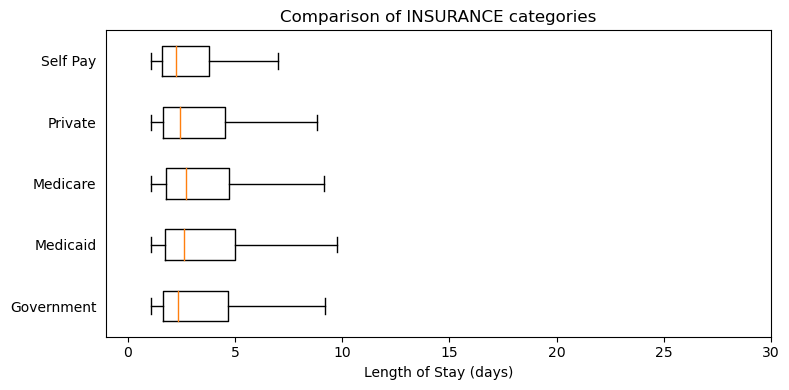

In [115]:
#Visualising the INSURANCE variable

# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):#categoricalvariable
    
    results = df_Final[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df_Final['LOS'].loc[df_Final[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('INSURANCE', los_range=(-1, 30))

# Observation
1. The Self-Pay category has the lowest LOS

In [101]:
#Appending Administrative Info from Admission Table

df_Final = pd.merge(df_Final, df[['SUBJECT_ID','HADM_ID','ADMITTIME' ,'ADMISSION_TYPE','INSURANCE','ETHNICITY','DIAGNOSIS','HOSPITAL_EXPIRE_FLAG']], on=['SUBJECT_ID','HADM_ID'], how='left')
df_Final

SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS  HEIGHT      WEIGHT  \
0               3   145834      211552   6.0646  179.07   96.800003   
1               4   185777      294638   1.6785     NaN         NaN   
2               6   107064      228232   3.6729     NaN         NaN   
3               9   150750      220597   5.3231  182.88  104.000000   
4              10   184167      288409   8.0921     NaN         NaN   
...           ...      ...         ...      ...     ...         ...   
34151       99985   176670      279638  11.2998     NaN         NaN   
34152       99991   151118      226241   3.1426     NaN  100.500000   
34153       99992   197084      242052   1.9745     NaN   65.400000   
34154       99995   137810      229633   2.1615   62.50   68.000000   
34155       99999   113369      246512   1.1242   60.00   96.500000   

       HEART_RATE_MEAN  HEART_RATE_MEDIAN  HEART_RATE_STD  RESP_RATE_MEAN  \
0           109.795455              102.5       28.270767       14.145833   
1            89.000000               89.0        7.577379       25.333333   
2            84.111111               83.0        5.852898       12.222222   
3            92.428571               91.0        7.362207       14.346939   
4           147.333333              148.0        8.870868             NaN   
...                ...                ...             ...             ...   
34151        88.928571               85.5       14.511626       21.264706   
34152       104.361702              104.0        7.822558       26.127660   
34153        69.600000               67.0        7.320064       16.080000   
34154        70.272727               74.0       13.877303       20.270270   
34155        94.703704               96.0        6.491502       18.555556   

       ...        GCS  CREATININE         DOB  GENDER            ADMITTIME  \
0      ...   4.000000    2.466667  2025-04-11       M  2101-10-20 19:08:00   
1      ...  15.000000    0.500000  2143-05-12       F  2191-03-16 00:28:00   
2      ...  15.000000   10.000000  2109-06-21       F  2175-05-30 07:15:00   
3      ...   5.608696    1.400000  2108-01-26       M  2149-11-09 13:06:00   
4      ...        NaN         NaN  2103-06-28       F  2103-06-28 11:36:00   
...    ...        ...         ...         ...     ...                  ...   
34151  ...        NaN    0.950000  2127-04-08       M  2181-01-27 02:47:00   
34152  ...        NaN    1.033333  2137-04-07       M  2184-12-24 08:30:00   
34153  ...        NaN    1.200000  2078-10-17       F  2144-07-25 18:03:00   
34154  ...        NaN    0.450000  2058-05-29       F  2147-02-08 08:00:00   
34155  ...        NaN    0.900000  2054-01-06       F  2117-12-30 07:15:00   

       ADMISSION_TYPE  INSURANCE               ETHNICITY  \
0           EMERGENCY   Medicare                   WHITE   
1           EMERGENCY    Private                   WHITE   
2            ELECTIVE   Medicare                   WHITE   
3           EMERGENCY   Medicaid         ETHNICITY_OTHER   
4             NEWBORN   Medicaid  BLACK/AFRICAN AMERICAN   
...               ...        ...                     ...   
34151       EMERGENCY    Private                   WHITE   
34152        ELECTIVE    Private                   WHITE   
34153       EMERGENCY   Medicare                   WHITE   
34154        ELECTIVE   Medicare                   WHITE   
34155        ELECTIVE   Medicare         HISPANIC/LATINO   

                                 DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  
0                              HYPOTENSION                     0  
1      FEVER,DEHYDRATION,FAILURE TO THRIVE                     0  
2                CHRONIC RENAL FAILURE/SDA                     0  
3                          HEMORRHAGIC CVA                     1  
4                                  NEWBORN                     0  
...                                    ...                   ...  
34151                                FEVER                     0  
34152                   DIVERTICULI

In [102]:
#Exclusion3
#Deceased Patients are not considered in our study as LOS will be biased.
df_Final=df_Final.loc[df_Final['HOSPITAL_EXPIRE_FLAG']==0]
df_Final
df_Final=df_Final.drop(["HOSPITAL_EXPIRE_FLAG"],axis=1)
df_Final.shape



(30685, 36)

In [103]:
#FEATURE EXTRACTION OF AGE 

#Obtaining the Age column from ADMITTIME and DOB(As DOB is dateshifted in MIMIC-III)

# subtract column 'DOB' from column 'ADMITTIME' to create a new column 'AGE'



from dateutil.relativedelta import relativedelta
from datetime import datetime

# convert the 'DOB' and 'ADMITTIME' columns to datetime objects
df_Final['DOB'] = pd.to_datetime(df_Final['DOB'])
df_Final['ADMITTIME'] = pd.to_datetime(df_Final['ADMITTIME'])
#As a part of MIMIC-III De-identification Process,
#DOB of patients aged above 89 is shifted to less than 1900, 
#such that the age is masked to 300 at the time of ICU admission for all patients

filt_89=(df_Final['DOB'].dt.year<1902)
df_Final.loc[~filt_89,'AGE'] = df_Final.apply(lambda row: relativedelta(row['ADMITTIME'], row['DOB']).years, axis=1)
df_Final.loc[filt_89,'AGE'] = 91.4
df_Final=df_Final.drop(['ADMITTIME','DOB'],axis=1)
df_Final['AGE'].isnull().sum()


df_Final

SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS  HEIGHT      WEIGHT  \
0               3   145834      211552   6.0646  179.07   96.800003   
1               4   185777      294638   1.6785     NaN         NaN   
2               6   107064      228232   3.6729     NaN         NaN   
4              10   184167      288409   8.0921     NaN         NaN   
5              11   194540      229441   1.5844     NaN         NaN   
...           ...      ...         ...      ...     ...         ...   
34151       99985   176670      279638  11.2998     NaN         NaN   
34152       99991   151118      226241   3.1426     NaN  100.500000   
34153       99992   197084      242052   1.9745     NaN   65.400000   
34154       99995   137810      229633   2.1615   62.50   68.000000   
34155       99999   113369      246512   1.1242   60.00   96.500000   

       HEART_RATE_MEAN  HEART_RATE_MEDIAN  HEART_RATE_STD  RESP_RATE_MEAN  \
0           109.795455              102.5       28.270767       14.145833   
1            89.000000               89.0        7.577379       25.333333   
2            84.111111               83.0        5.852898       12.222222   
4           147.333333              148.0        8.870868             NaN   
5            84.730769               86.0        8.431169       18.166667   
...                ...                ...             ...             ...   
34151        88.928571               85.5       14.511626       21.264706   
34152       104.361702              104.0        7.822558       26.127660   
34153        69.600000               67.0        7.320064       16.080000   
34154        70.272727               74.0       13.877303       20.270270   
34155        94.703704               96.0        6.491502       18.555556   

       ...  TEMP_MEDIAN  TEMP_STD        GCS  CREATININE  GENDER  \
0      ...    37.099998  0.376143   4.000000    2.466667       M   
1      ...    36.666667  0.406227  15.000000    0.500000       F   
2      ...    36.500000  0.414275  15.000000   10.000000       F   
4      ...          NaN       NaN        NaN         NaN       F   
5      ...    36.833335  0.354281  14.769231    0.700000       F   
...    ...          ...       ...        ...         ...     ...   
34151  ...    37.666667  0.618308        NaN    0.950000       M   
34152  ...    37.250000  0.427182        NaN    1.033333       M   
34153  ...    36.444444  0.304290        NaN    1.200000       F   
34154  ...    36.944444  0.351364        NaN    0.450000       F   
34155  ...    37.333333  0.439790        NaN    0.900000       F   

       ADMISSION_TYPE  INSURANCE               ETHNICITY  \
0           EMERGENCY   Medicare                   WHITE   
1           EMERGENCY    Private                   WHITE   
2            ELECTIVE   Medicare                   WHITE   
4             NEWBORN   Medicaid  BLACK/AFRICAN AMERICAN   
5           EMERGENCY    Private                   WHITE   
...               ...        ...                     ...   
34151       EMERGENCY    Private                   WHITE   
34152        ELECTIVE    Private                   WHITE   
34153       EMERGENCY   Medicare                   WHITE   
34154        ELECTIVE   Medicare                   WHITE   
34155        ELECTIVE   Medicare         HISPANIC/LATINO   

                                 DIAGNOSIS   AGE  
0                              HYPOTENSION  76.0  
1      FEVER,DEHYDRATION,FAILURE TO THRIVE  47.0  
2                CHRONIC RENAL FAILURE/SDA  65.0  
4                                  NEWBORN   0.0  
5                               BRAIN MASS  50.0  
...                                    ...   ...  
34151                                FEVER  53.0  
34152                   DIVERTICULITIS/SDA  47.0  
34153           RETROPERITONEAL HEMORRHAGE  65.0  
34154        ABDOMINAL AORTIC ANEURYSM/SDA  88.0  
34155                SPONDYLOLISTHESIS/SDA  63.0  

[30685 rows x 35 columns]

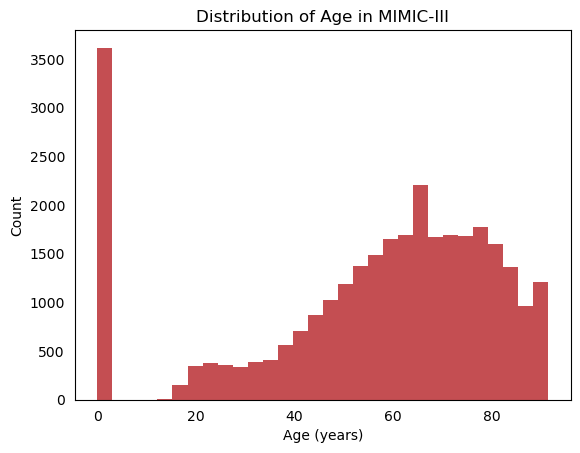

In [104]:
#AGE VISUALIZATION
plt.hist(df_Final['AGE'], bins=30, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();


In [105]:
#Exclusion4
#Neonates will not be considered in this study.Hence patients above the age of 15 is included.
df_Final= df_Final.loc[(df_Final["AGE"]>15)]
df_Final.head()
df_Final.shape

(27067, 35)

In [106]:
#The SERVICES table helps identifying the type of service a patient is receiving in the hospital.
df_services.head()

ROW_ID  SUBJECT_ID  HADM_ID         TRANSFERTIME PREV_SERVICE CURR_SERVICE
0     758         471   135879  2122-07-22 14:07:27        TSURG          MED
1     759         471   135879  2122-07-26 18:31:49          MED        TSURG
2     760         472   173064  2172-09-28 19:22:15          NaN         CMED
3     761         473   129194  2201-01-09 20:16:45          NaN           NB
4     762         474   194246  2181-03-23 08:24:41          NaN           NB

In [107]:
#In the SERVICES table, there is possibility of multiple rows for the same combination of SUBJECT_ID and HADM_ID, 
#representing the patients who have been admitted to multiple ICU in the same admission window.
#Since in this study, we are concerned only with the 1st ICU stay, we obtain the corresponding rows from Services Table

df_services_1ststay=(df_services.sort_values(['HADM_ID',"TRANSFERTIME"]).
                       groupby(['HADM_ID']).
                       head(1))

In [108]:

#Appending Services Info from Services Table
df_Final = pd.merge(df_Final, df_services_1ststay[['HADM_ID','CURR_SERVICE']], on=['HADM_ID'], how='left')


In [109]:
df_Final.dtypes

SUBJECT_ID             int64
HADM_ID                int64
ICUSTAY_ID             int64
LOS                  float64
HEIGHT               float64
WEIGHT               float64
HEART_RATE_MEAN      float64
HEART_RATE_MEDIAN    float64
HEART_RATE_STD       float64
RESP_RATE_MEAN       float64
RESP_RATE_MEDIAN     float64
RESP_RATE_STD        float64
BP_SYS_MEAN          float64
BP_SYS_MEDIAN        float64
BP_SYS_STD           float64
BP_DIA_MEAN          float64
BP_DIA_MEDIAN        float64
BP_DIA_STD           float64
BP_MEAN_MEAN         float64
BP_MEAN_MEDIAN       float64
BP_MEAN_STD          float64
O2SAT_MEAN           float64
O2SAT_MEDIAN         float64
O2SAT_STD            float64
TEMP_MEAN            float64
TEMP_MEDIAN          float64
TEMP_STD             float64
GCS                  float64
CREATININE           float64
GENDER                object
ADMISSION_TYPE        object
INSURANCE             object
ETHNICITY             object
DIAGNOSIS             object
AGE           

In [110]:
#Count of each category of services
df_Final['CURR_SERVICE'].isnull().sum()#Only 5 records has NaN values

5

In [113]:
#Unique Service categories 

df_Final['CURR_SERVICE'].value_counts()

MED      9313
CMED     4666
CSURG    3536
SURG     2141
TRAUM    1965
NSURG    1806
NMED     1205
TSURG     615
VSURG     532
OMED      384
ORTHO     361
GU        188
GYN       110
PSURG     109
ENT        97
OBS        31
DENT        3
Name: CURR_SERVICE, dtype: int64

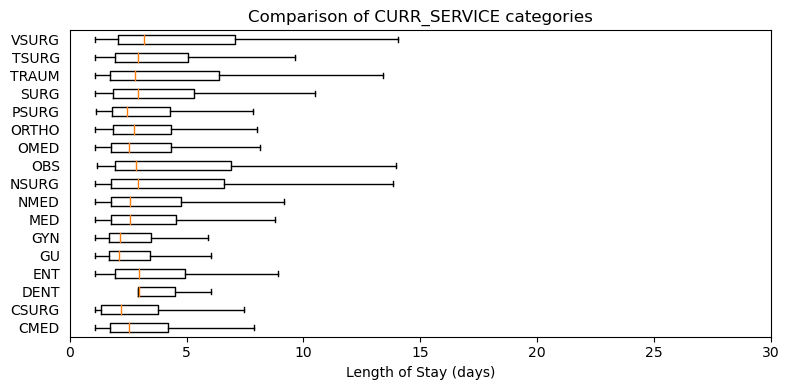

In [116]:
#Visualising the Services Variable
boxplot_los_groupby('CURR_SERVICE', los_range=(0, 30))

In [117]:
#Checking for Sepsis
filtered_df=df_Final[df_Final["DIAGNOSIS"].str.contains(r'\bSEPSIS\b',case = False,na=False)]
print(len(filtered_df["DIAGNOSIS"]))

697


In [118]:

#FEATURE ENGINEERING 
#Identifying SEPSIS from DIAGNOSIS(AT ADMISSION) to highlight impact of SEPSIS on Length of Stay
#Checking for Sepsis
df_Final.loc[~df_Final['DIAGNOSIS'].isna(), 'DIAGNOSIS'] = df_Final.loc[~df_Final['DIAGNOSIS'].isna(), 'DIAGNOSIS'].str.contains(r'\bSEPSIS\b',case = False).replace({True: '1', False: '0'})
df_Final['DIAGNOSIS'] = df_Final['DIAGNOSIS'].fillna('0')
#df_Final=df_Final['DIAGNOSIS'].astype(int)

df_Final= df_Final.rename(columns={'DIAGNOSIS': 'SEPSIS'})
df_Final


SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS  HEIGHT      WEIGHT  \
0               3   145834      211552   6.0646  179.07   96.800003   
1               4   185777      294638   1.6785     NaN         NaN   
2               6   107064      228232   3.6729     NaN         NaN   
3              11   194540      229441   1.5844     NaN         NaN   
4              13   143045      263738   3.6660  144.78   72.849998   
...           ...      ...         ...      ...     ...         ...   
27062       99985   176670      279638  11.2998     NaN         NaN   
27063       99991   151118      226241   3.1426     NaN  100.500000   
27064       99992   197084      242052   1.9745     NaN   65.400000   
27065       99995   137810      229633   2.1615   62.50   68.000000   
27066       99999   113369      246512   1.1242   60.00   96.500000   

       HEART_RATE_MEAN  HEART_RATE_MEDIAN  HEART_RATE_STD  RESP_RATE_MEAN  \
0           109.795455              102.5       28.270767       14.145833   
1            89.000000               89.0        7.577379       25.333333   
2            84.111111               83.0        5.852898       12.222222   
3            84.730769               86.0        8.431169       18.166667   
4            85.821429               84.0       18.024785       15.357143   
...                ...                ...             ...             ...   
27062        88.928571               85.5       14.511626       21.264706   
27063       104.361702              104.0        7.822558       26.127660   
27064        69.600000               67.0        7.320064       16.080000   
27065        70.272727               74.0       13.877303       20.270270   
27066        94.703704               96.0        6.491502       18.555556   

       ...  TEMP_STD        GCS  CREATININE  GENDER  ADMISSION_TYPE  \
0      ...  0.376143   4.000000    2.466667       M       EMERGENCY   
1      ...  0.406227  15.000000    0.500000       F       EMERGENCY   
2      ...  0.414275  15.000000   10.000000       F        ELECTIVE   
3      ...  0.354281  14.769231    0.700000       F       EMERGENCY   
4      ...  0.598758  11.750000    0.633333       F       EMERGENCY   
...    ...       ...        ...         ...     ...             ...   
27062  ...  0.618308        NaN    0.950000       M       EMERGENCY   
27063  ...  0.427182        NaN    1.033333       M        ELECTIVE   
27064  ...  0.304290        NaN    1.200000       F       EMERGENCY   
27065  ...  0.351364        NaN    0.450000       F        ELECTIVE   
27066  ...  0.439790        NaN    0.900000       F        ELECTIVE   

       INSURANCE        ETHNICITY  SEPSIS   AGE  CURR_SERVICE  
0       Medicare            WHITE       0  76.0         VSURG  
1        Private            WHITE       0  47.0           MED  
2       Medicare            WHITE       0  65.0          SURG  
3        Private            WHITE       0  50.0         NSURG  
4       Medicaid            WHITE       0  39.0          CMED  
...          ...              ...     ...   ...           ...  
27062    Private            WHITE       0  53.0           MED  
27063    Private            WHITE       0  47.0          SURG  
27064   Medicare            WHITE       0  65.0           MED  
27065   Medicare            WHITE       0  88.0         VSURG  
27066   Medicare  HISPANIC/LATINO       0  63.0         NSURG  

[27067 rows x 36 columns]

In [119]:
df_Final["SEPSIS"].value_counts()

0    26370
1      697
Name: SEPSIS, dtype: int64

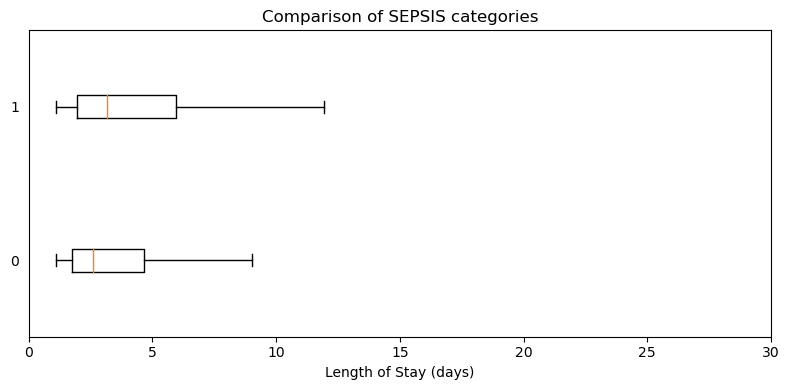

In [120]:
#Visualising the SEPSIS Variable
boxplot_los_groupby('SEPSIS', los_range=(0, 30))

# Observation
1. The patients diagnosed with SEPSIS has higher LOS.

### DATA CLEANUP PRIOR TO FEATURE SELECTION

In [408]:
#Handling Missing Values

df_Final.isnull().sum()

SUBJECT_ID              0
HADM_ID                 0
ICUSTAY_ID              0
LOS                     0
HEIGHT              16575
WEIGHT               8485
HEARTRATE_MEAN        351
HEARTRATE_MEDIAN      351
HEARTRATE_STD         354
RESP_RATE_MEAN        378
RESP_RATE_MEDIAN      378
RESP_RATE_STD         399
BP_SYS_MEAN           372
BP_SYS_MEDIAN         372
BP_SYS_STD            381
BP_DIA_MEAN           372
BP_DIA_MEDIAN         372
BP_DIA_STD            382
BP_MEAN_MEAN          353
BP_MEAN_MEDIAN        353
BP_MEAN_STD           354
O2SAT_MEAN            356
O2SAT_MEDIAN          356
O2SAT_STD             364
TEMP_MEAN             773
TEMP_MEDIAN           773
TEMP_STD             1002
GCS                 11513
CREATININE            529
GENDER                  0
ADMISSION_TYPE          0
INSURANCE               0
ETHNICITY               0
SEPSIS                  0
AGE                     0
CURR_SERVICE            5
dtype: int64

In [409]:
df_Final.shape

(27067, 36)

In [175]:
#Dropping columns of Weight,Height and GCS as lot of entries are missing
df_Final_1=df_Final.drop(['HEIGHT','WEIGHT','GCS'], axis=1)

In [176]:
df_Final_1.isnull().sum()

SUBJECT_ID              0
HADM_ID                 0
ICUSTAY_ID              0
LOS                     0
HEART_RATE_MEAN       351
HEART_RATE_MEDIAN     351
HEART_RATE_STD        354
RESP_RATE_MEAN        378
RESP_RATE_MEDIAN      378
RESP_RATE_STD         399
BP_SYS_MEAN           372
BP_SYS_MEDIAN         372
BP_SYS_STD            381
BP_DIA_MEAN           372
BP_DIA_MEDIAN         372
BP_DIA_STD            382
BP_MEAN_MEAN          353
BP_MEAN_MEDIAN        353
BP_MEAN_STD           354
O2SAT_MEAN            356
O2SAT_MEDIAN          356
O2SAT_STD             364
TEMP_MEAN             773
TEMP_MEDIAN           773
TEMP_STD             1002
CREATININE            529
GENDER                  0
ADMISSION_TYPE          0
INSURANCE               0
ETHNICITY               0
SEPSIS                  0
AGE                     0
CURR_SERVICE            5
dtype: int64

In [177]:
#Missing Values in Numerical Variables
def impute_missing_values_num(data,columns):
    for column in columns:
        data[column]=data[column].fillna(data[column].mean())

Numerical_Columns_Null=['HEART_RATE_MEAN','HEART_RATE_MEDIAN','HEART_RATE_STD',"RESP_RATE_MEAN","RESP_RATE_MEDIAN","RESP_RATE_STD","BP_SYS_MEAN", "BP_SYS_MEDIAN","BP_SYS_STD","BP_DIA_MEAN","BP_DIA_MEDIAN","BP_DIA_STD", "BP_MEAN_MEAN", "BP_MEAN_MEDIAN","BP_MEAN_STD" ,"O2SAT_MEAN","O2SAT_MEDIAN","O2SAT_STD", "TEMP_MEAN", "TEMP_MEDIAN","TEMP_STD",'CREATININE']
impute_missing_values_num(df_Final_1,Numerical_Columns_Null)    
df_Final_1.isnull().sum() 

SUBJECT_ID           0
HADM_ID              0
ICUSTAY_ID           0
LOS                  0
HEART_RATE_MEAN      0
HEART_RATE_MEDIAN    0
HEART_RATE_STD       0
RESP_RATE_MEAN       0
RESP_RATE_MEDIAN     0
RESP_RATE_STD        0
BP_SYS_MEAN          0
BP_SYS_MEDIAN        0
BP_SYS_STD           0
BP_DIA_MEAN          0
BP_DIA_MEDIAN        0
BP_DIA_STD           0
BP_MEAN_MEAN         0
BP_MEAN_MEDIAN       0
BP_MEAN_STD          0
O2SAT_MEAN           0
O2SAT_MEDIAN         0
O2SAT_STD            0
TEMP_MEAN            0
TEMP_MEDIAN          0
TEMP_STD             0
CREATININE           0
GENDER               0
ADMISSION_TYPE       0
INSURANCE            0
ETHNICITY            0
SEPSIS               0
AGE                  0
CURR_SERVICE         5
dtype: int64

In [178]:
#DROPPING ID COLUMNS
df_Final_1=df_Final_1.drop(['SUBJECT_ID','HADM_ID','ICUSTAY_ID'],axis=1)

In [179]:
df_Final_1.dtypes

LOS                  float64
HEART_RATE_MEAN      float64
HEART_RATE_MEDIAN    float64
HEART_RATE_STD       float64
RESP_RATE_MEAN       float64
RESP_RATE_MEDIAN     float64
RESP_RATE_STD        float64
BP_SYS_MEAN          float64
BP_SYS_MEDIAN        float64
BP_SYS_STD           float64
BP_DIA_MEAN          float64
BP_DIA_MEDIAN        float64
BP_DIA_STD           float64
BP_MEAN_MEAN         float64
BP_MEAN_MEDIAN       float64
BP_MEAN_STD          float64
O2SAT_MEAN           float64
O2SAT_MEDIAN         float64
O2SAT_STD            float64
TEMP_MEAN            float64
TEMP_MEDIAN          float64
TEMP_STD             float64
CREATININE           float64
GENDER                object
ADMISSION_TYPE        object
INSURANCE             object
ETHNICITY             object
SEPSIS                object
AGE                  float64
CURR_SERVICE          object
dtype: object

In [180]:
#Missing Values in Categorical Variables

df_Final_1['CURR_SERVICE'] = df_Final_1['CURR_SERVICE'].fillna("UNKNOWN_SERVICE")
df_Final_1.isnull().sum()



LOS                  0
HEART_RATE_MEAN      0
HEART_RATE_MEDIAN    0
HEART_RATE_STD       0
RESP_RATE_MEAN       0
RESP_RATE_MEDIAN     0
RESP_RATE_STD        0
BP_SYS_MEAN          0
BP_SYS_MEDIAN        0
BP_SYS_STD           0
BP_DIA_MEAN          0
BP_DIA_MEDIAN        0
BP_DIA_STD           0
BP_MEAN_MEAN         0
BP_MEAN_MEDIAN       0
BP_MEAN_STD          0
O2SAT_MEAN           0
O2SAT_MEDIAN         0
O2SAT_STD            0
TEMP_MEAN            0
TEMP_MEDIAN          0
TEMP_STD             0
CREATININE           0
GENDER               0
ADMISSION_TYPE       0
INSURANCE            0
ETHNICITY            0
SEPSIS               0
AGE                  0
CURR_SERVICE         0
dtype: int64

In [165]:
df_Final_3.dtypes

LOS                  float64
HEIGHT               float64
WEIGHT               float64
HEART_RATE_MEAN      float64
HEART_RATE_MEDIAN    float64
HEART_RATE_STD       float64
RESP_RATE_MEAN       float64
RESP_RATE_MEDIAN     float64
RESP_RATE_STD        float64
BP_SYS_MEAN          float64
BP_SYS_MEDIAN        float64
BP_SYS_STD           float64
BP_DIA_MEAN          float64
BP_DIA_MEDIAN        float64
BP_DIA_STD           float64
BP_MEAN_MEAN         float64
BP_MEAN_MEDIAN       float64
BP_MEAN_STD          float64
O2SAT_MEAN           float64
O2SAT_MEDIAN         float64
O2SAT_STD            float64
TEMP_MEAN            float64
TEMP_MEDIAN          float64
TEMP_STD             float64
GCS                  float64
CREATININE           float64
GENDER                object
ADMISSION_TYPE        object
INSURANCE             object
ETHNICITY             object
SEPSIS                object
AGE                  float64
CURR_SERVICE          object
BMI                  float64
dtype: object

In [166]:
df_Final_3.shape

(5586, 34)

In [181]:
#Finding Statistical Parameters of the features
df_Final_1.describe()

LOS  HEART_RATE_MEAN  HEART_RATE_MEDIAN  HEART_RATE_STD  \
count  27067.000000     27067.000000       27067.000000    27067.000000   
mean       4.612932        85.376292          84.788228        8.694385   
std        6.190780        14.952143          15.314871        4.377044   
min        1.100000        31.192308          31.000000        0.000000   
25%        1.743600        75.066667          74.000000        5.857061   
50%        2.619000        84.636364          84.000000        7.899075   
75%        4.689200        94.687500          94.000000       10.515318   
max      153.928000       154.333333         155.000000      166.104316   

       RESP_RATE_MEAN  RESP_RATE_MEDIAN  RESP_RATE_STD   BP_SYS_MEAN  \
count    27067.000000      27067.000000   27067.000000  27067.000000   
mean        18.499280         18.227627       3.799923    119.435763   
std          3.772366          4.013054       1.554025     16.082192   
min          3.918919          0.000000       0.000000     56.538462   
25%         15.916667         15.500000       2.763790    107.709005   
50%         17.972222         18.000000       3.529873    117.333333   
75%         20.440000         20.000000       4.508003    129.040833   
max         42.500000         44.000000      16.562005    197.280000   

       BP_SYS_MEDIAN    BP_SYS_STD  ...  BP_MEAN_MEDIAN   BP_MEAN_STD  \
count   27067.000000  27067.000000  ...    27067.000000  27067.000000   
mean      119.098783     14.773876  ...       77.854265     10.941071   
std        16.596062      5.934686  ...       10.922635      5.078443   
min        72.000000      0.577350  ...       34.000000      1.414214   
25%       107.000000     10.743776  ...       70.000000      7.841551   
50%       117.000000     13.802757  ...       76.500000      9.977763   
75%       129.000000     17.491404  ...       84.000000     12.659682   
max       199.000000     72.255178  ...      142.000000     85.808054   

         O2SAT_MEAN  O2SAT_MEDIAN     O2SAT_STD     TEMP_MEAN   TEMP_MEDIAN  \
count  27067.000000  27067.000000  27067.000000  27067.000000  27067.000000   
mean      97.359322     97.714593      1.980187     36.899470     36.932530   
std        1.845885      1.961425      1.586635      0.570994      0.601301   
min       52.277778     60.500000      0.000000     32.611111     32.611111   
25%       96.346154     96.500000      1.259890     36.531746     36.555556   
50%       97.578947     98.000000      1.742236     36.888889     36.916667   
75%       98.695652     99.000000      2.297858     37.236111     37.299999   
max      100.000000    100.000000     39.781470     40.198246     40.100000   

           TEMP_STD    CREATININE           AGE  
count  27067.000000  27067.000000  27067.000000  
mean       0.521913      1.248265     62.901578  
std        0.280260      1.323732     17.529023  
min        0.000000      0.100000     16.000000  
25%        0.327259      0.700000     52.000000  
50%        0.481888      0.900000     65.000000  
75%        0.657342      1.248265     77.000000  
max        7.130069     29.966667     91.400000  

[8 rows x 24 columns]

In [182]:
#HANDLING CATEGORICAL VARIABLES
#ONE HOT ENCODING

columns_one_hot=['INSURANCE','ETHNICITY','GENDER',"CURR_SERVICE"]

df_Final_1=pd.get_dummies(df_Final_1,columns=columns_one_hot,dtype=int,drop_first=True)

In [183]:
#LABEL ENCODING(ORDINAL VARIBLES)
df_Final_1['ADMISSION_TYPE']=df_Final_1['ADMISSION_TYPE'].map({'ELECTIVE':1,'URGENT':2,'EMERGENCY':3})
df_Final_1['SEPSIS']=df_Final_1['SEPSIS'].map({'0':0,'1':1})
df_Final_1.head()

LOS  HEART_RATE_MEAN  HEART_RATE_MEDIAN  HEART_RATE_STD  RESP_RATE_MEAN  \
0  6.0646       109.795455              102.5       28.270767       14.145833   
1  1.6785        89.000000               89.0        7.577379       25.333333   
2  3.6729        84.111111               83.0        5.852898       12.222222   
3  1.5844        84.730769               86.0        8.431169       18.166667   
4  3.6660        85.821429               84.0       18.024785       15.357143   

   RESP_RATE_MEDIAN  RESP_RATE_STD  BP_SYS_MEAN  BP_SYS_MEDIAN  BP_SYS_STD  \
0              18.0       7.562476   100.792453           98.0   26.281288   
1              25.0       2.890146   118.750000          119.0   11.737816   
2              12.0       2.846500   154.194444          152.0   15.807448   
3              18.0       2.239306   105.115385          105.5    8.668688   
4              14.0       3.519410   123.960000          123.0   17.843019   

   ...  CURR_SERVICE_NSURG  CURR_SERVICE_OBS  CURR_SERVICE_OMED  \
0  ...                   0                 0                  0   
1  ...                   0                 0                  0   
2  ...                   0                 0                  0   
3  ...                   1                 0                  0   
4  ...                   0                 0                  0   

   CURR_SERVICE_ORTHO  CURR_SERVICE_PSURG  CURR_SERVICE_SURG  \
0                   0                   0                  0   
1                   0                   0                  0   
2                   0                   0                  1   
3                   0                   0                  0   
4                   0                   0                  0   

   CURR_SERVICE_TRAUM  CURR_SERVICE_TSURG  CURR_SERVICE_UNKNOWN_SERVICE  \
0                   0                   0                             0   
1                   0                   0                             0   
2                   0                   0                             0   
3                   0                   0                             0   
4                   0                   0                             0   

   CURR_SERVICE_VSURG  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 52 columns]

In [173]:
#Converting to.csv file

#df_Final
df_Final_1.to_csv('ICU_LOS_MIMIC_III_5.csv',index=False)

In [184]:
#Feature Selection
#Performing Pearson Correlation
X=df_Final.drop('LOS',axis=1)   #Feature Matrix
Y=df_Final['LOS']

In [185]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size= 0.3,random_state= 0)

/var/folders/2b/mxs2y0j506l2tzs7whhsrr5h0000gp/T/ipykernel_4123/4036603163.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=X_train.corr()


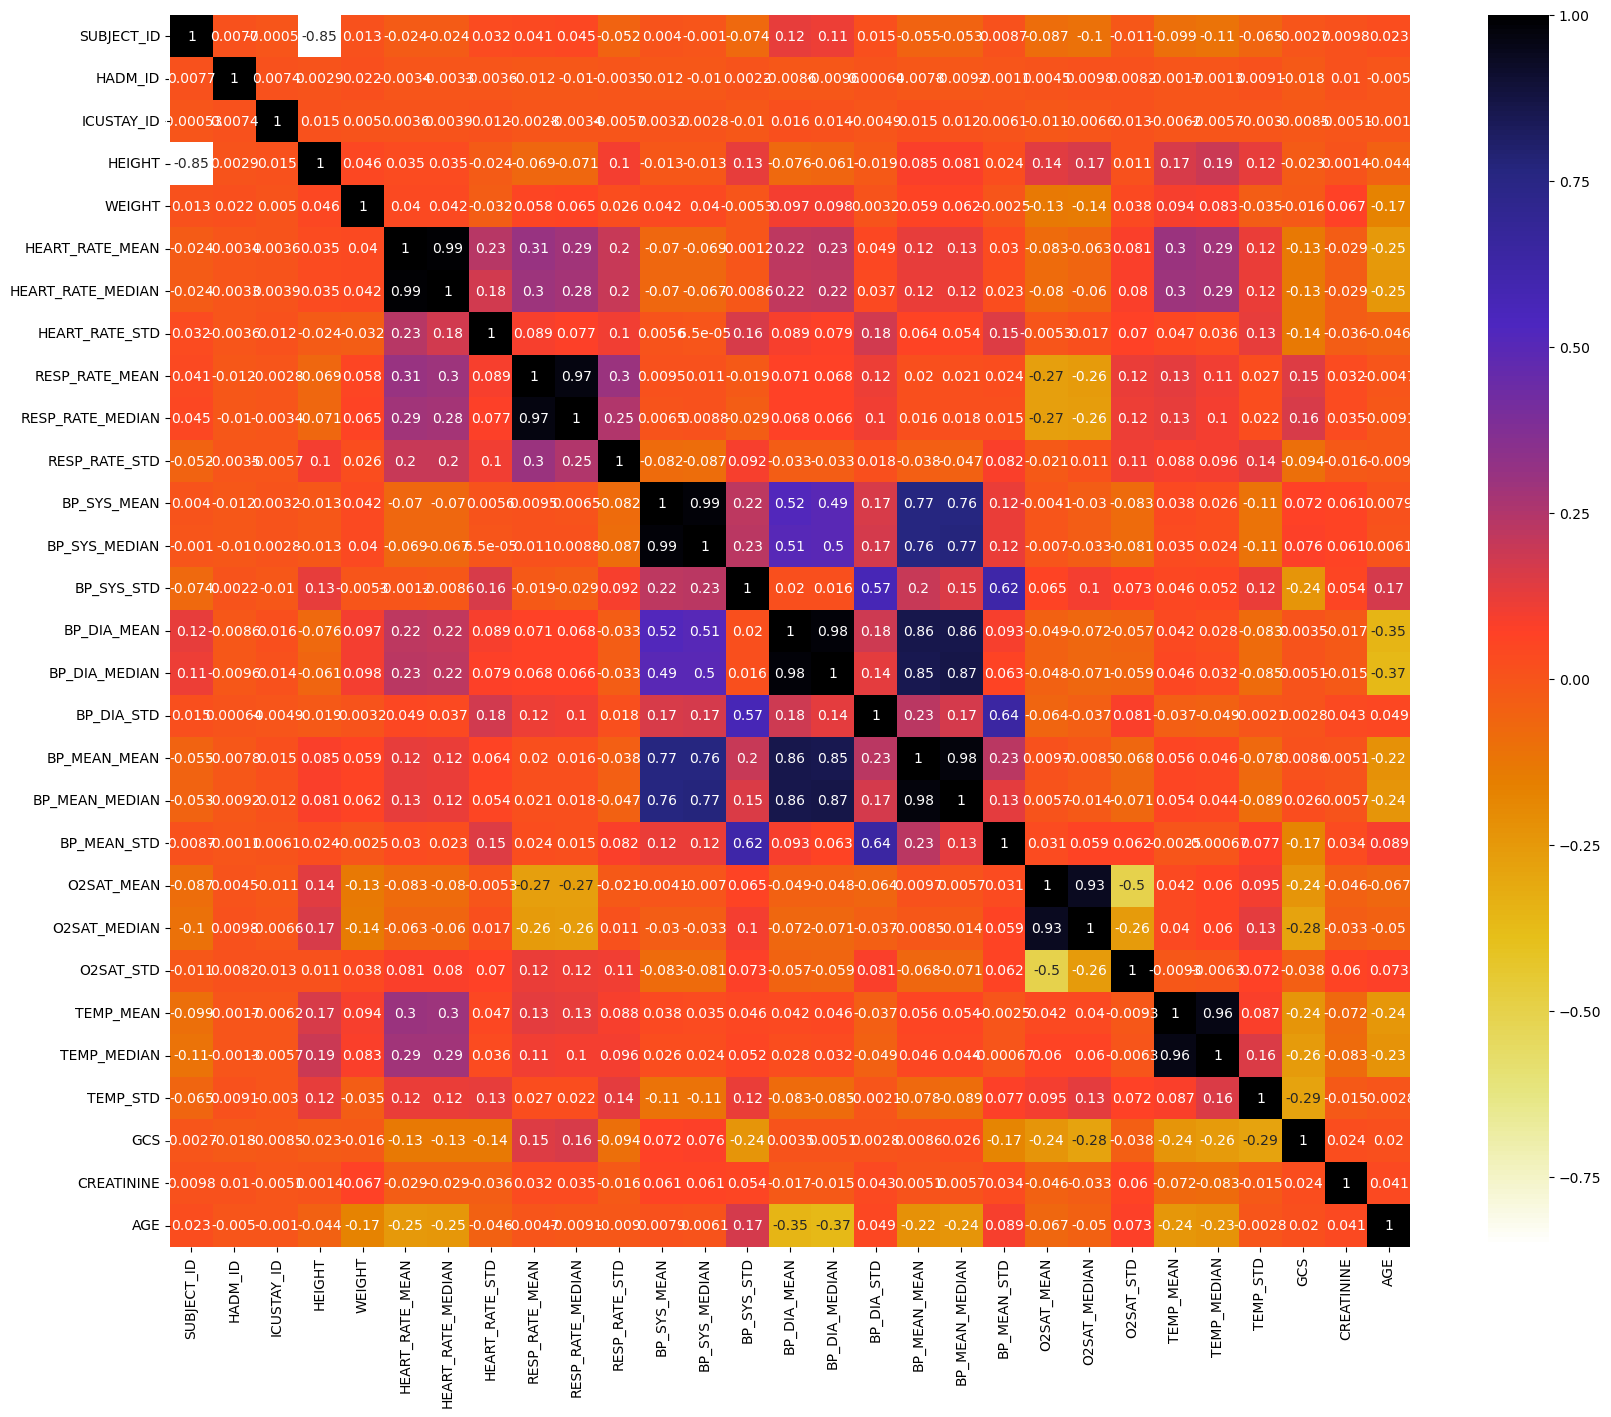

In [186]:
#Using Pearson Correlation
plt.figure(figsize=(20,16))
cor=X_train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

# Observations from Pearson Correlation Matrix

1. Data highlights the fact that the older age group has Medicare Insurance(Govt).(AGE Vs INSURANCE_MEDICARE : 0.66)
2. Data highlights the fact that the younger age group prefers Private Insurance.(AGE Vs INSURANCE_PRIVATE :-0.46)
3. Observation 1 and 2 strengthens that Medicare and Private are negatively correlated. (INSURANCE_MEDICARE Vs INSURANCE_PRIVATE:-0.77)
4. Data highlights the fact that most surgeries are Elective. (ADMISSION TYPE Vs SURG_HISTORY :-0.46)

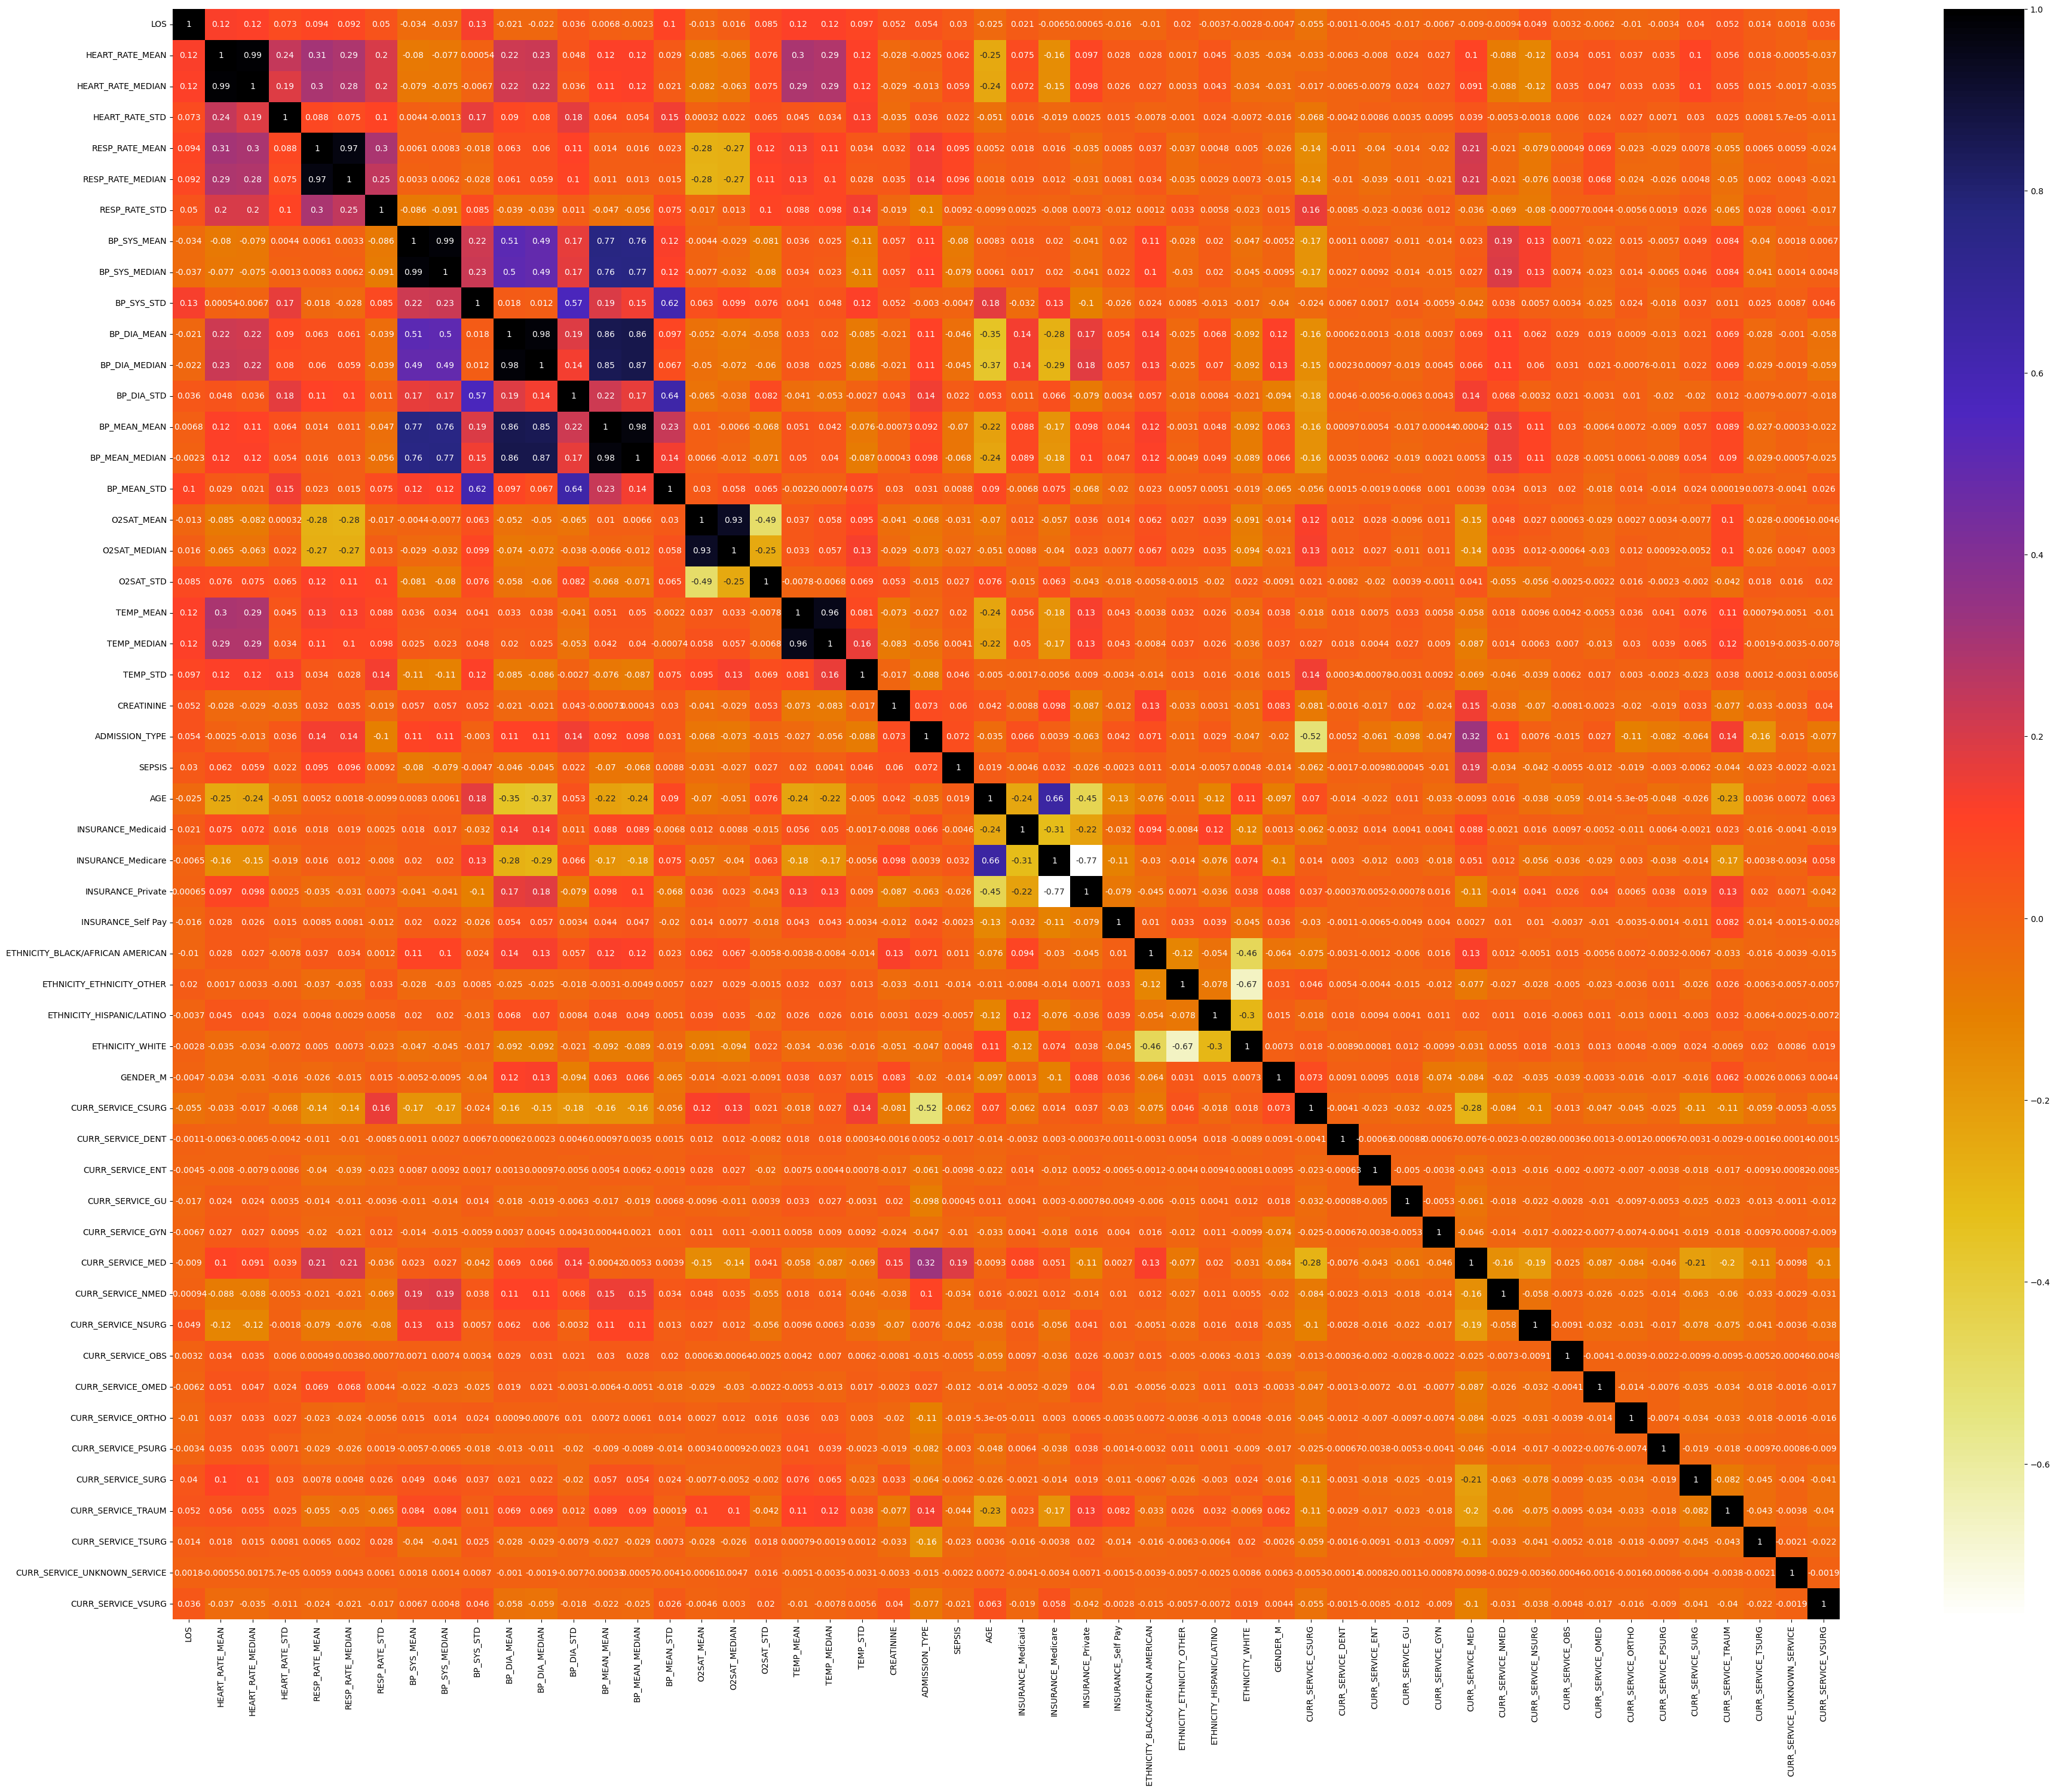

In [187]:
#Using Pearson Correlation to decide which features contributes most to the target
plt.figure(figsize=(45,35))
cor=df_Final_1.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

In [188]:
df_Final_1.corr()

LOS  HEART_RATE_MEAN  \
LOS                               1.000000         0.122355   
HEART_RATE_MEAN                   0.122355         1.000000   
HEART_RATE_MEDIAN                 0.115911         0.986487   
HEART_RATE_STD                    0.073046         0.241917   
RESP_RATE_MEAN                    0.094069         0.309174   
RESP_RATE_MEDIAN                  0.091534         0.292062   
RESP_RATE_STD                     0.050135         0.201286   
BP_SYS_MEAN                      -0.034250        -0.079652   
BP_SYS_MEDIAN                    -0.036873        -0.077053   
BP_SYS_STD                        0.133304         0.000543   
BP_DIA_MEAN                      -0.020705         0.221519   
BP_DIA_MEDIAN                    -0.021664         0.227456   
BP_DIA_STD                        0.035539         0.048333   
BP_MEAN_MEAN                      0.006792         0.117295   
BP_MEAN_MEDIAN                   -0.002265         0.119457   
BP_MEAN_STD                       0.104161         0.028540   
O2SAT_MEAN                       -0.013196        -0.084699   
O2SAT_MEDIAN                      0.016367        -0.065204   
O2SAT_STD                         0.085373         0.075674   
TEMP_MEAN                         0.118956         0.297652   
TEMP_MEDIAN                       0.116805         0.285830   
TEMP_STD                          0.097201         0.118539   
CREATININE                        0.052488        -0.028480   
ADMISSION_TYPE                    0.053983        -0.002530   
SEPSIS                            0.029788         0.061798   
AGE                              -0.025295        -0.245897   
INSURANCE_Medicaid                0.021178         0.075008   
INSURANCE_Medicare               -0.006486        -0.155118   
INSURANCE_Private                 0.000650         0.097476   
INSURANCE_Self Pay               -0.015753         0.028156   
ETHNICITY_BLACK/AFRICAN AMERICAN -0.010306         0.028069   
ETHNICITY_ETHNICITY_OTHER         0.019813         0.001681   
ETHNICITY_HISPANIC/LATINO        -0.003718         0.045022   
ETHNICITY_WHITE                  -0.002802        -0.034965   
GENDER_M                         -0.004735        -0.033715   
CURR_SERVICE_CSURG               -0.054768        -0.033372   
CURR_SERVICE_DENT                -0.001071        -0.006250   
CURR_SERVICE_ENT                 -0.004533        -0.008001   
CURR_SERVICE_GU                  -0.017017         0.023615   
CURR_SERVICE_GYN                 -0.006709         0.027405   
CURR_SERVICE_MED                 -0.008989         0.102420   
CURR_SERVICE_NMED                -0.000941        -0.087891   
CURR_SERVICE_NSURG                0.048539        -0.123690   
CURR_SERVICE_OBS                  0.003249         0.033511   
CURR_SERVICE_OMED                -0.006153         0.050818   
CURR_SERVICE_ORTHO               -0.010302         0.036639   
CURR_SERVICE_PSURG               -0.003410         0.034555   
CURR_SERVICE_SURG                 0.039887         0.104981   
CURR_SERVICE_TRAUM                0.051513         0.056357   
CURR_SERVICE_TSURG                0.014409         0.018070   
CURR_SERVICE_UNKNOWN_SERVICE      0.001775        -0.000549   
CURR_SERVICE_VSURG                0.035792        -0.036914   

                                  HEART_RATE_MEDIAN  HEART_RATE_STD  \
LOS                                        0.115911        0.073046   
HEART_RATE_MEAN                            0.986487        0.241917   
HEART_RATE_MEDIAN                          1.000000        0.188950   
HEART_RATE_STD                             0.188950        1.000000   
RESP_RATE_MEAN                             0.297345        0.087833   
RESP_RATE_MEDIAN                           0.281781        0.074745   
RESP_RATE_STD                              0.198466        0.104882   
BP_SYS_MEAN                               -0.078985        0.004384   
BP_SYS_MEDIAN                             -0.075411       -0

In [432]:
#Converting to.csv file


df_Final_1.to_csv('ICU_LOS_MIMIC_III_4.csv',index=False)

In [430]:
df_Final_1_1=df_Final_1.drop(['HEARTRATE_MEDIAN','RESP_RATE_MEDIAN','BP_SYS_MEAN','BP_DIA_MEAN','BP_MEAN_MEAN','BP_MEAN_STD','BP_MEAN_MEDIAN','TEMP_MEAN','O2SAT_MEAN','CURR_SERVICE_CSURG','ETHNICITY_WHITE','INSURANCE_Medicare'], axis=1)

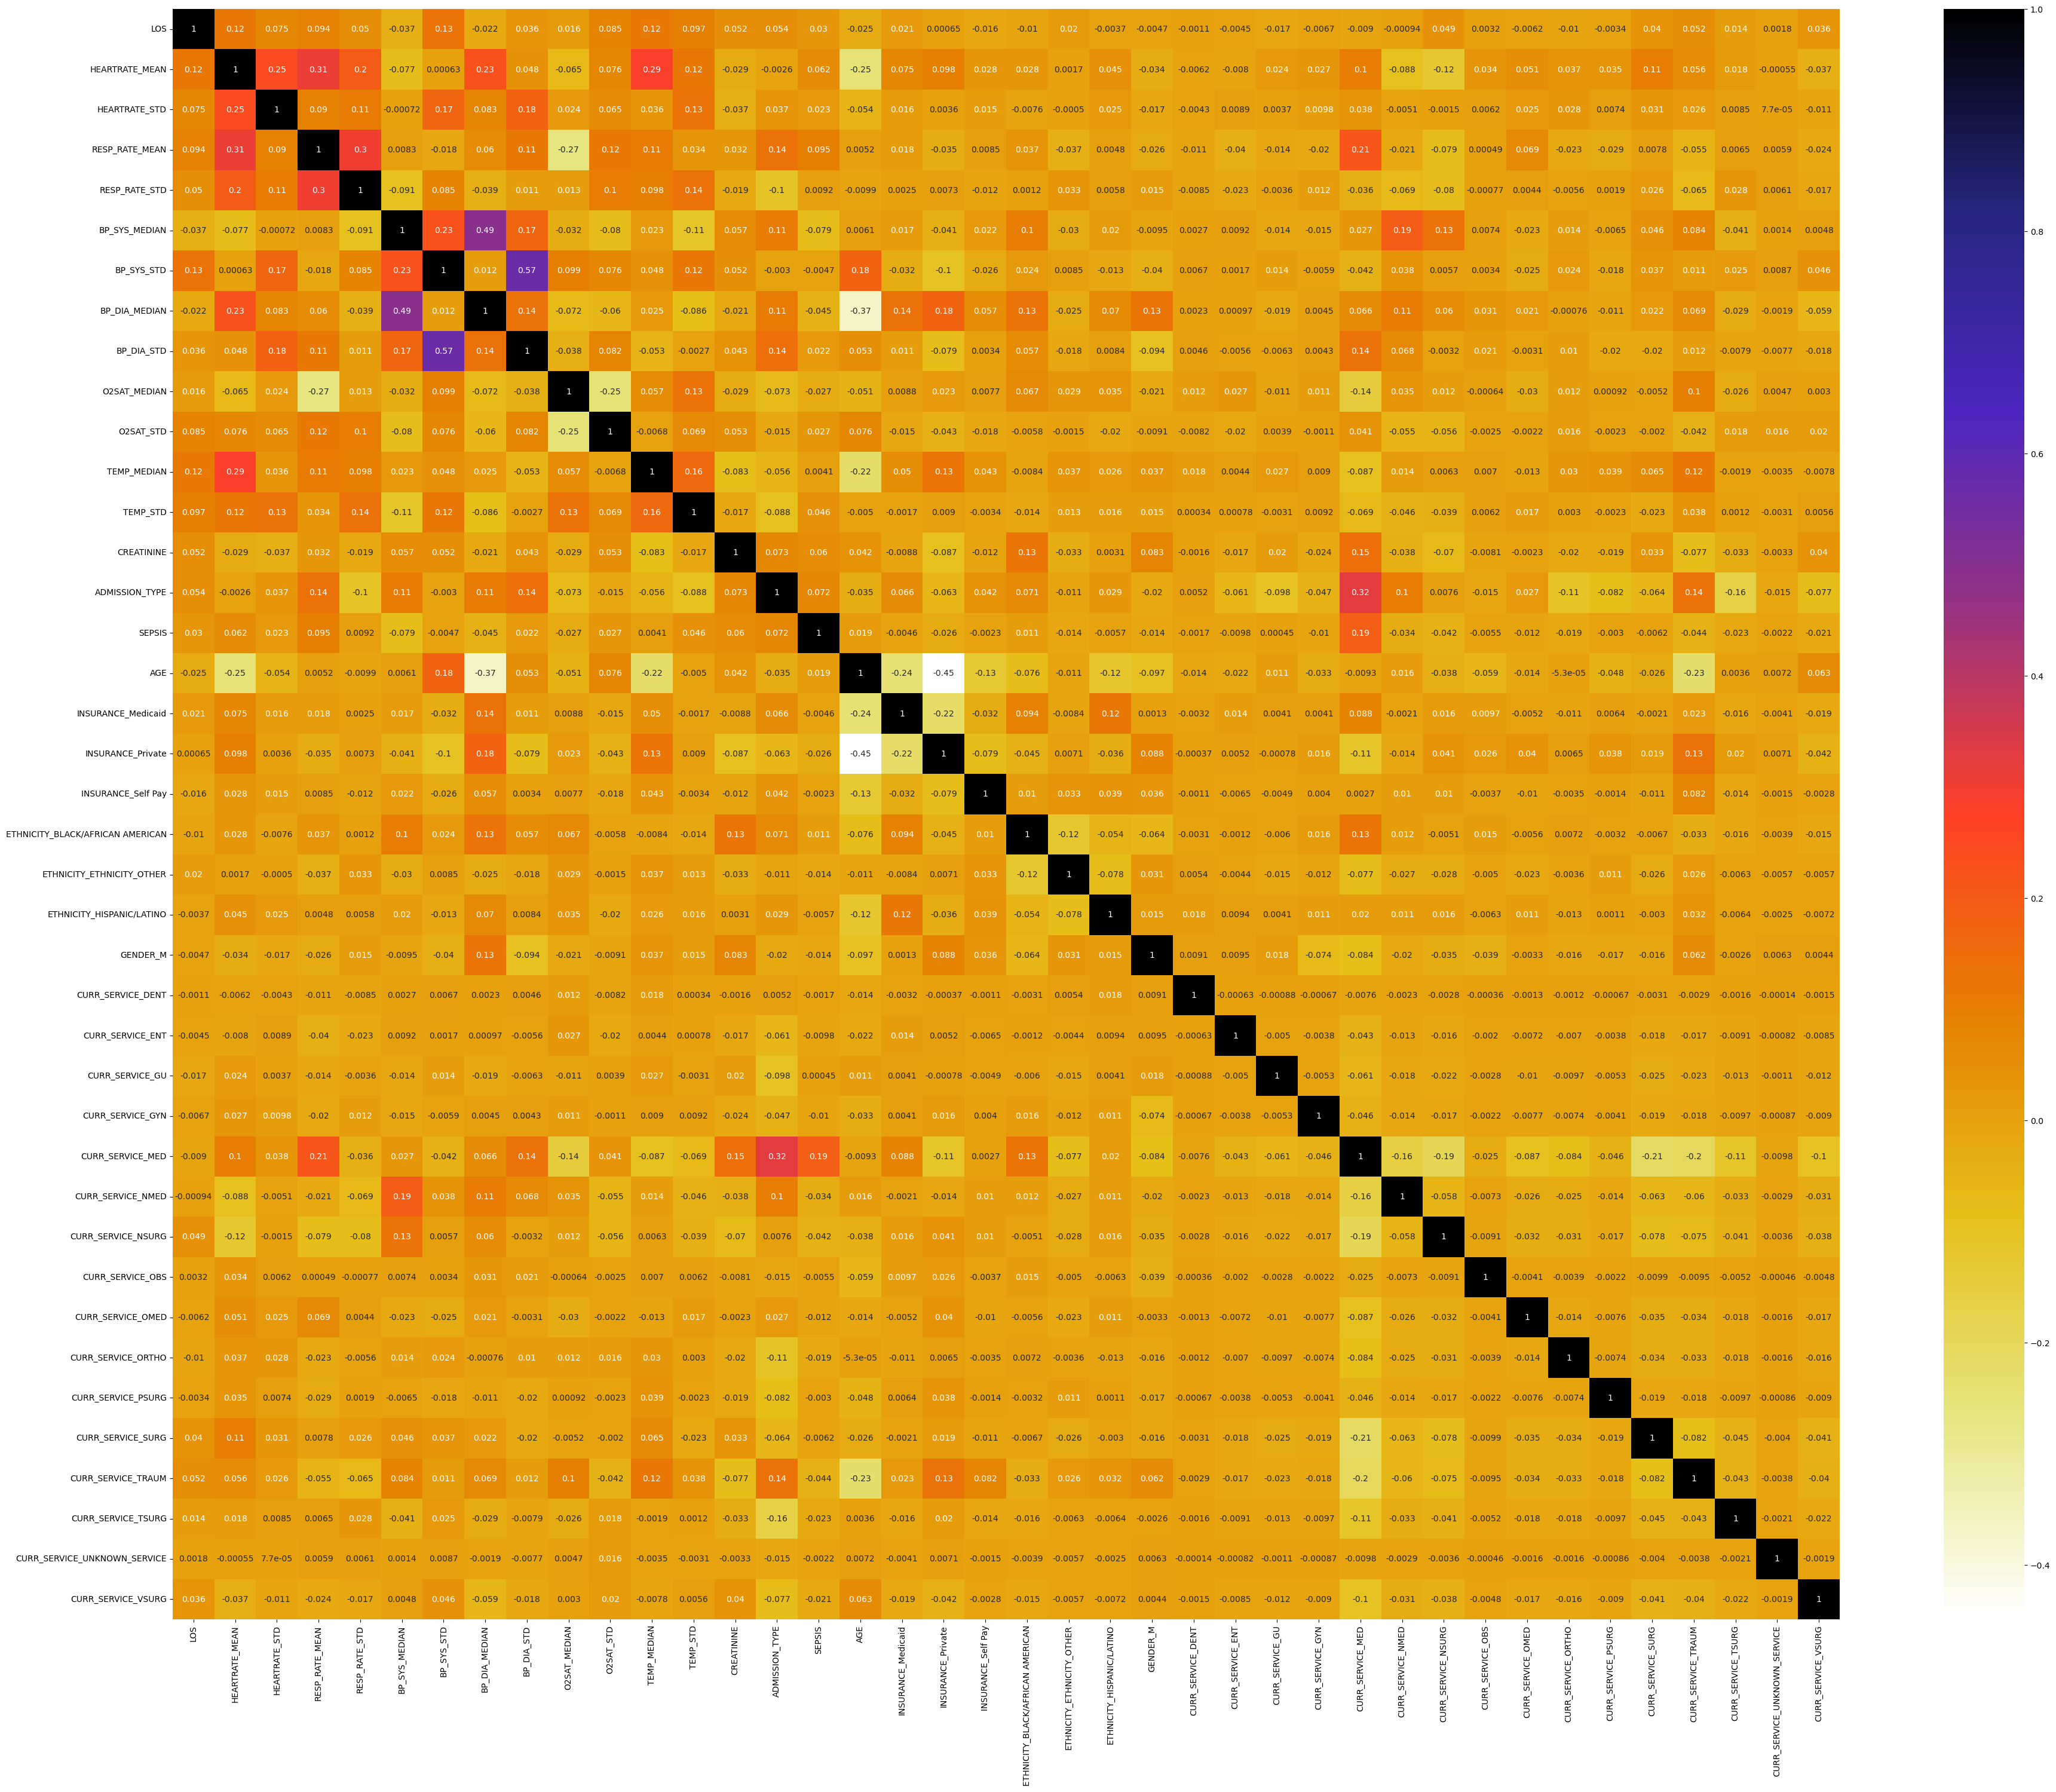

In [431]:
#Using Pearson Correlation to decide which features contributes most to the target
plt.figure(figsize=(45,35))
cor=df_Final_1_1.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)
plt.show()

In [428]:
df_Final_1_1.shape

(27067, 41)